<br>

<font size="7">INDEX</font>

<br>
<br>

<font size="5">
<ul>
    <li><a href="#fn_[1]" name="[1]">Part 1</a></li>
    <br>
    <li><a href="#fn_[2]" name="[2]">Part 2</a></li>
    <br>
    <li><a href="#fn_[3]" name="[3]">Part 3</a></li>
</ul>
</font>

Introductory comment: This file contains a lot of statements on my thought processes, this has been explicitly demanded by the requirements for this assignment.

In [ ]:
#installs:
!conda install -c conda-forge beautifulsoup4 --yes 
!conda install -c conda-forge geocoder --yes 
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium --yes

In [ ]:
#imports:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bsoup
from ibm_botocore.client import Config
import ibm_boto3 
import geocoder
import re
from geopy.geocoders import Nominatim
import folium
import json
from pandas.io.json import json_normalize
from time import sleep as pause
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import types

In [ ]:
# Cell containg the Foursquare Credentials and Version
CLIENT_ID = '#' # your Foursquare ID
CLIENT_SECRET = '#' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [ ]:
# This cell would be hidden.
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': '#',
    'IBM_API_KEY_ID': '#m',
    'ENDPOINT': '#',
    'IBM_AUTH_ENDPOINT': '#',
    'BUCKET': '#'
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

<-

<br>
<br>
<br>

<font size="7"><a href="#[1]" name="fn_[1]">Part 1</a></font>

<br>
<br>
<br>
<br>

The task of the first part is to scrape the wikipedia page on the postal codes of Canada and to return pandas dataframe containing an index, the PostalCode, the Borough, and the Neighborhood.

First, we need to download the wikipedia page, in order to scrape it for the desired data, we use the "requests" library. Also, our task will involve creating a pandas dataframe.

Let us now define the URL of the wikipedia page we want to scrape:

In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

Next, the html file is downloaded:

In [3]:
WIKIHTML = requests.get(URL)

Next, let us verify if the downloaded document contains HTML code, via the .headers method of the requests library.

If the file contains HTML code, the sequence "text/html" will be the value of the "Content-Type" key, from the resulting dictionary of the .headers method.

In [4]:
print(WIKIHTML.headers["Content-Type"])

text/html; charset=UTF-8


Great, the wikipedia page is formatted in HTML code, as expected.

Note that it says "text/html", thus we can access the HTML code via the .text method:

In [5]:
print(WIKIHTML.text)

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XjZO1QpAMFIAALOzc6EAAACH","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":935851093,"wgRevisionId":935851093,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario

A nice way to scrape HTML files is using the library "bs4", which is an acronym for Beautiful Soup version 4. For a detailed explanation, please refer to the homepage of said library.

Now lets convert the HTML file into a text document, tell BeautifulSoup that this text document is a HTML document, so that BeautifulSoup knows that the file is a HTML file and interprets is as such, and create a BeautifulSoup object this way.

In [8]:
WHTML = bsoup(WIKIHTML.text, "html.parser")

Now, we check the HTML file sourcecode for the place where the desired information is stored. It is no suprise, that the information is stored in a HTML-table, with the class "wikitable sortable". Let us now find all the tables contained in the HTML-document via the "tbody"-tag.

In [9]:
print(WHTML.find_all("tbody"))

[<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North Yo

We can quickly see, that only the first table contains our desired information. Thus, we create a new list, which contains all tables, and then only choose the first table as our object:

In [13]:
WHTABLE = WHTML.find_all("tbody")[0]

Before creating a pandas object, we need to add the HTML "table" and "/table" tags at the start and end of the document. We can do this using the insert_before and insert_after methods, however unfortunately they don't work with the WHTABLE object. Let's check it's type:

In [15]:
type(WHTABLE)

bs4.element.Tag

We can see, that WHTABLE is no "pure" BeautifulSoup object. Originally, I tried converting the WHTABLE into a BeautifulSoup object and then executing the insert_before() and insert_after() methods, however they would not work.

Thus I decided to convert the WHTABLE object into a string, and added the needed tags via the replace method:

In [60]:
WHT_v_1_0 = str(WHTABLE).replace("<tbody>","<table><tbody>").replace("</tbody>","</tbody></table>")

Now we convert this string into a BeautifulSoup object, which is readable by pandas:

In [61]:
WHT = bsoup(WHT_v_1_0)
print(type(WHT))
WHT

<class 'bs4.BeautifulSoup'>


<html><body><table><tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="No

Now, let's create a pandas object of that HTML table using the pandas .read_html method:

In [62]:
pdWH_list = pd.read_html(WHT.prettify(), flavor='bs4')
type(pdWH_list)

list

As we can see, the extraction returned a list. Now I tried converting the list into a dataframe, which expectedly didn't work. However, I was irritated because the pdWH object looks like a list. I remembered that almost any type can be stored in e.g. lists. and tried to extract the first element of the list, which then was the dataframe we needed:

In [63]:
print(type(pdWH_list[0]))
pdWH = pdWH_list[0]
pdWH.head()

<class 'pandas.core.frame.DataFrame'>


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Now, we will rename "PostCode" to "PostalCode".

In [64]:
pdWH.columns = ['PostalCode','Borough','Neighborhood']
pdWH.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Let's check the dataframes dimensions:

In [65]:
pdWH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 3 columns):
PostalCode      287 non-null object
Borough         287 non-null object
Neighborhood    287 non-null object
dtypes: object(3)
memory usage: 6.8+ KB


We have 287 objects in the dataframe. Now, all cells containing a "Not assigned" Borough will be counted and removed.

In [66]:
deletedobjects = 0

for i, row in pdWH.iterrows():
    if row["Borough"] == "Not assigned":
        pdWH.drop(index=i, inplace=True)
        deletedobjects += 1
    else:
        pass

print(str(deletedobjects) + " rows have been deleted!")

77 rows have been deleted!


Let's verify if it:

In [67]:
pdWH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 2 to 285
Data columns (total 3 columns):
PostalCode      210 non-null object
Borough         210 non-null object
Neighborhood    210 non-null object
dtypes: object(3)
memory usage: 6.6+ KB


The number of deleted objects is 77 and 287 - 210 is 77. Perfect! However, the index is not longer correct. Let's reset it:

In [68]:
pdWH.reset_index(inplace=True)

pdWH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
index           210 non-null int64
PostalCode      210 non-null object
Borough         210 non-null object
Neighborhood    210 non-null object
dtypes: int64(1), object(3)
memory usage: 6.6+ KB


Note that the dataframe contains 4 columns, one of them is an index column which contains the old indices. We will remove it:

In [69]:
pdWH.drop("index", axis=1, inplace=True)
pdWH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
PostalCode      210 non-null object
Borough         210 non-null object
Neighborhood    210 non-null object
dtypes: object(3)
memory usage: 5.0+ KB


Now, for all "Neighbourhoods" with a "Not assigned" value, we will let them inherit the "Borough" value:

In [70]:
replacedobjects = 0

for i, row in pdWH.iterrows():
    if row["Neighborhood"] == "Not assigned":
        print(pdWH.loc[i])
        pdWH.loc[i,"Neighborhood"] = pdWH.loc[i,"Borough"]
        print("Neighborhood with index " + str(i) + " has been replaced by its Borough!")
        replacedobjects += 1
    else:
        pass
    
print("In " + str(replacedobjects) + " row(s), the missing neighborhood was replaced by the borough's name.")

PostalCode               M9A
Borough         Queen's Park
Neighborhood    Not assigned
Name: 6, dtype: object
Neighborhood with index 6 has been replaced by its Borough!
In 1 row(s), the missing neighborhood was replaced by the borough's name.


In [71]:
pdWH.loc[6]

PostalCode               M9A
Borough         Queen's Park
Neighborhood    Queen's Park
Name: 6, dtype: object

Now, we will sort the objects in the dataframe by their PostalCode and then merge all entries with a duplicate PostalCode, but not via the merge method:

In [79]:
# Sorting the objects by their PostalCode
pdWH_sorted = pdWH.sort_values(by=["PostalCode"])
# Reindexing the sorted dataframe
pdWH_sorted.reset_index(inplace=True)
pdWH_sorted.drop("index", axis=1, inplace=True)

old_value = ""

upperlimit = (pdWH_sorted.count(axis=0)[0]-1)

for i, row in pdWH_sorted.iterrows():
    if i < upperlimit:
        if i == 0:
            pass
        elif row["PostalCode"] ==  pdWH_sorted.loc[i-1,"PostalCode"]:
            old_value = pdWH_sorted.loc[i,"PostalCode"]
            pdWH_sorted.loc[i,"Neighborhood"] = pdWH_sorted.loc[i,"Neighborhood"] + "," + pdWH_sorted.loc[i-1,"Neighborhood"]
            pdWH_sorted.drop(index=i-1, inplace=True)
        else:
            pass
    else:
        pass
    
pdWH_sorted.reset_index(inplace=True)
pdWH_sorted.drop("index", axis=1, inplace=True)   

pdWH_sorted

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"West Hill,Morningside,Guildwood"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park,Ionview,East Birchmount Park"
7,M1L,Scarborough,"Clairlea,Oakridge,Golden Mile"
8,M1M,Scarborough,"Cliffside,Scarborough Village West,Cliffcrest"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [74]:
pdWH_sorted.shape

(103, 3)

The next field contains instructions to export the pdWH dataframe, since this then allows to reimport it, without running the above code.

In [ ]:
pdWH_sorted.to_csv("AWeek3Part1.csv", index = None, header=True)

cos.upload_file(Filename='AWeek3Part1.csv',Bucket=credentials['BUCKET'],Key='AWeek3Part1.csv')

!!! The following cell is intended to be run, if one needs the data of Part 1 and continues in Part 2, without having to run all instructions again !!!

In [ ]:
cos.download_file(Bucket=credentials['BUCKET'],Key='AWeek3Part1.csv',Filename='AWeek3Part1.csv')

pdWH_sorted = pd.read_csv("AWeek3Part1.csv")

<br>
<br>
<br>

<font size="7"><a href="#[2]" name="fn_[2]">Part 2</a></font>

<br>
<br>
<br>
<br>

In this part of the week 3 assignment, we are required to get the Latitude and Longitude of each PostalCode and append the information to each row in the dataframe. In order to do that, we need to use the geocoder API.

First, we create an empty Latitude and Longitude column in the Dataframe, which we will fill with actual data in the following steps:

In [85]:
PCoord = pdWH_sorted.assign(Latitude="",Longitude="")

Next we will fill the respective columns and rows with coordinates:

In [47]:
for i, row in PCoord.iterrows():
    
    postal_code = row["PostalCode"]
    
    lat_lng_coords = None
    
    #while(lat_lng_coords is None):
    #Loop and indentation removed for testing purposes, 
    #however the final code, if it would work, should be run with the loop.
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng
    #Starting here: No identation of the while loop instructions.    
    PCoord.log[i,"Latitude"] = lat_lng_coords[0]
    PCoord.log[i,"Longitude"] = lat_lng_coords[1]
    
PCoord
#None-Type returned, see https://www.coursera.org/learn/applied-data-science-capstone/peer/I1bDq/segmenting-and-clustering-neighborhoods-in-toronto/discussions/threads/d629jOBHQM-tvYzgR7DPHw
#Possible solution: using a US based server.

TypeError: 'NoneType' object is not subscriptable

Because the code returns a "NoneType", I will continue with the provided .csv file. The following cell contains code which loads a Bucket. For this process, some credentials are necessary, which have been removed from the next cell.

In [87]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Next, we will check if the number of rows of the imported dataframe and of our dataframe match, this will be useful for merging the two dataframes.

In [88]:
print(df_data_0.describe().loc["count","Latitude"])

103.0


In [89]:
print(PCoord.describe().loc["count","Latitude"])

103


In order to merge the dataframes, and because our intended method doesn't work, we will delete the "Latitude" and "Longitutde" columns again, because the merging of two dataframes is much faster and easier, than the looping through both.

In [90]:
PCoord.drop(columns=["Latitude","Longitude"],inplace=True)

Now we merge the imported and the existing dataframe on the "PostalCode" column:

In [91]:
cdf = PCoord.merge(df_data_0, left_on='PostalCode', right_on='Postal Code')
cdf.head()

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


Now, we drop the additional "Postal Code" column:

In [92]:
cdf.drop(columns="Postal Code",inplace=True)

cdf.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [93]:
cdf

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park,Ionview,East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Oakridge,Golden Mile",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside,Scarborough Village West,Cliffcrest",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


Next, we export the dataframe for convenience:

In [ ]:
cdf.to_csv("AWeek3Part2.csv", index = None, header=True)

cos.upload_file(Filename='AWeek3Part2.csv',Bucket=credentials['BUCKET'],Key='AWeek3Part2.csv')

This cell is intended to be run upon continuing with Part 3, based on a freshly loaded notebook instance.

In [ ]:
cos.download_file(Bucket=credentials['BUCKET'],Key='AWeek3Part2.csv',Filename='AWeek3Part2.csv')

cdf = pd.read_csv("AWeek3Part2.csv")

<br>
<br>
<br>

<font size="7"><a href="#[3]" name="fn_[3]">Part 3</a></font>

<br>
<br>
<br>
<br>

In this part of the exam we are required to explore and cluster the neighborhoods in Toronto, thus we will focus on exploring and clustering boroughs with the name "Toronto" in them.

First we create an empty dataframe containg all necessary columns called cdfT:

In [94]:
cdfT = pd.DataFrame(columns=["PostalCode","Borough","Neighborhood","Latitude","Longitude"])
cdfT

,PostalCode,Borough,Neighborhood,Latitude,Longitude


In order to scan the boroughs for boroughs with "Toronto" in the name, we will use the regular expressions library.

Next we scan for the respective boroughs using a wildcard regular expression and the term "Toronto":

In [96]:
regex = re.compile('(.*)Toronto')

for i, row in cdf.iterrows():
    
    row_values = []
    
    if re.match(regex, row["Borough"]):
        current_row_value = pd.DataFrame([pd.Series(row.values)])
        current_row_value.columns = ["PostalCode","Borough","Neighborhood","Latitude","Longitude"]
        cdfT = cdfT.append(current_row_value)
    else:
        pass

cdfT

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
0,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
0,M4L,East Toronto,"India Bazaar,The Beaches West",43.668999,-79.315572
0,M4M,East Toronto,Studio District,43.659526,-79.340923
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
0,M4P,Central Toronto,Davisville North,43.712751,-79.390197
0,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
0,M4S,Central Toronto,Davisville,43.704324,-79.388790
0,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
0,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,Summerhill ...",43.686412,-79.400049


First, we use Nominatim from the geopy library and retrieve the coordinates of Toronto, in order to center the map on Toronto.

Next, we get the latitude and longitude of Toronto using the geocode method of the geopy library:

In [99]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto explored")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [100]:
#Run this cell in case of continuation:
latitude = 43.653963
longitude = -79.387207

Next, we will use folium to create a map of Toronto:

In [103]:
#To make sense of the next statement, the latitude-coordinate of Toronto \
#is hardcoded in this cell. 
#The hardcoded value is the one retrieved from the Nominatim method.

latitude = 43.653963

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Since not all boroughs of Toronto are displayed in the current frame, we shift the latitude a bit northwards and repeat the creation of the map:

In [104]:
latitude = latitude + 0.025

In [106]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now, we have a map of toronto with the centers of all boroughs displayed as blue dots. Next, we need to retrieve properties which we can use to cluster the different areas.

For this purpose, we will use the Foursquare API.

One interesting property to investigate would be, how the top 100 venues of Toronto are distributed, and which "Postal Code" area has the most venues out of the top 100 venues. 

This could be interesting if one plans to make a trip to Toronto and wants to live as close as possible to as many of the top venues as possible.

We will now draw a circle with a radius of 8 kilometers around the center of the map, this should encompass all possible candidate venues and generate a query url.

Please continue running the cells at "Continue here:" after "Fetching of the results:"

In [ ]:
#radius = 8000
#LIMIT = 100
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT)

#This cell has been run, without loading the necessary credentials, to prevent someone from copying the credentials.

Fetching of the results:

In [73]:
#The following query has been commented out, to prevent an unintended usage of the Foursquare quota.
#results = requests.get(url).json()
#results

{'meta': {'code': 200, 'requestId': '5e3f4263aba2977c4b5ffcf8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 43.75096307200007,
    'lng': -79.28783811692936},
   'sw': {'lat': 43.60696292799992, 'lng': -79.48657588307064}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52ced2c9498e67e1059cf3b2',
       'name': 'Greenhouse Juice Co',
       'location': {'address': '5 MacPherson Ave.',
        'crossStreet': 'Yonge St.',
        'lat': 43.67910117808306,
        'lng': -79.39068555107286,
        'labeledLatLngs': [{'label': 'display',


Continue here: Please run the following cell to continue with the following cells.

In [109]:
results = {'meta': {'code': 200, 'requestId': '5e3f4263aba2977c4b5ffcf8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 43.75096307200007,
    'lng': -79.28783811692936},
   'sw': {'lat': 43.60696292799992, 'lng': -79.48657588307064}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52ced2c9498e67e1059cf3b2',
       'name': 'Greenhouse Juice Co',
       'location': {'address': '5 MacPherson Ave.',
        'crossStreet': 'Yonge St.',
        'lat': 43.67910117808306,
        'lng': -79.39068555107286,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67910117808306,
          'lng': -79.39068555107286}],
        'distance': 280,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['5 MacPherson Ave. (Yonge St.)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d112941735',
         'name': 'Juice Bar',
         'pluralName': 'Juice Bars',
         'shortName': 'Juice Bar',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-52ced2c9498e67e1059cf3b2-0'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aea405ef964a52082ba21e3',
       'name': 'LCBO',
       'location': {'address': '10 Scrivener Sq.',
        'crossStreet': 'at Yonge St.',
        'lat': 43.68149682937831,
        'lng': -79.39126079276781,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68149682937831,
          'lng': -79.39126079276781}],
        'distance': 431,
        'postalCode': 'M4W 3Y9',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['10 Scrivener Sq. (at Yonge St.)',
         'Toronto ON M4W 3Y9',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d186941735',
         'name': 'Liquor Store',
         'pluralName': 'Liquor Stores',
         'shortName': 'Liquor Store',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_liquor_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4aea405ef964a52082ba21e3-1'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad88fa9f964a520511221e3',
       'name': 'Black Camel',
       'location': {'address': '4 Crescent Rd',
        'crossStreet': 'Yonge',
        'lat': 43.67701587839681,
        'lng': -79.38936661984528,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67701587839681,
          'lng': -79.38936661984528}],
        'distance': 277,
        'postalCode': 'M4W 1S9',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['4 Crescent Rd (Yonge)',
         'Toronto ON M4W 1S9',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1df931735',
         'name': 'BBQ Joint',
         'pluralName': 'BBQ Joints',
         'shortName': 'BBQ',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bbqalt_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad88fa9f964a520511221e3-2'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5282572111d2f33612220715',
       'name': 'Boxcar Social',
       'location': {'address': '1208 Yonge St.',
        'crossStreet': 'Summerhill',
        'lat': 43.681749741301466,
        'lng': -79.39144664398965,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.681749741301466,
          'lng': -79.39144664398965}],
        'distance': 461,
        'postalCode': 'M4T 1W1',
        'cc': 'CA',
        'neighborhood': 'Summerhill',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['1208 Yonge St. (Summerhill)',
         'Toronto ON M4T 1W1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5282572111d2f33612220715-3'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55007fd7498ed027fd04b664',
       'name': 'Page & Panel: The TCAF Shop',
       'location': {'address': '789 Yonge St.',
        'crossStreet': 'Asquith Ave',
        'lat': 43.67165281613454,
        'lng': -79.38714090280968,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67165281613454,
          'lng': -79.38714090280968}],
        'distance': 813,
        'postalCode': 'M4W 2G8',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['789 Yonge St. (Asquith Ave)',
         'Toronto ON M4W 2G8',
         'Canada']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b18',
         'name': 'Comic Shop',
         'pluralName': 'Comic Shops',
         'shortName': 'Comic Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/comic_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-55007fd7498ed027fd04b664-4'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57f03361498e6431043a9608',
       'name': 'Sabai Sabai',
       'location': {'address': '81 Bloor St E',
        'lat': 43.670647205466466,
        'lng': -79.38485656424602,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.670647205466466,
          'lng': -79.38485656424602}],
        'distance': 944,
        'postalCode': 'M4W 1A9',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['81 Bloor St E', 'Toronto ON M4W 1A9', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d149941735',
         'name': 'Thai Restaurant',
         'pluralName': 'Thai Restaurants',
         'shortName': 'Thai',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-57f03361498e6431043a9608-5'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c061f964a520a3f720e3',
       'name': "Joso's",
       'location': {'address': '202 Davenport Road',
        'lat': 43.67483469176536,
        'lng': -79.39617148340865,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67483469176536,
          'lng': -79.39617148340865}],
        'distance': 855,
        'postalCode': 'M5R 1J2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['202 Davenport Road',
         'Toronto ON M5R 1J2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c0941735',
         'name': 'Mediterranean Restaurant',
         'pluralName': 'Mediterranean Restaurants',
         'shortName': 'Mediterranean',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c061f964a520a3f720e3-6'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '554ea8bd498efa064ec03031',
       'name': 'Paramount Fine Foods',
       'location': {'address': '1250 Bay Street',
        'lat': 43.67067671443592,
        'lng': -79.38986486034777,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67067671443592,
          'lng': -79.38986486034777}],
        'distance': 946,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['1250 Bay Street', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-554ea8bd498efa064ec03031-7'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5b2d934e59c423002c0c6db6',
       'name': 'Eataly',
       'location': {'address': '55 Bloor St W',
        'crossStreet': 'at Bay St',
        'lat': 43.66975356278464,
        'lng': -79.3887197971344,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66975356278464,
          'lng': -79.3887197971344}],
        'distance': 1032,
        'postalCode': 'M4W 1A5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['55 Bloor St W (at Bay St)',
         'Toronto ON M4W 1A5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1f5941735',
         'name': 'Gourmet Shop',
         'pluralName': 'Gourmet Shops',
         'shortName': 'Gourmet',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_gourmet_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5b2d934e59c423002c0c6db6-8'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c05ef964a520d9f620e3',
       'name': 'Royal Ontario Museum',
       'location': {'address': "100 Queen's Pk",
        'crossStreet': 'at Bloor St. W.',
        'lat': 43.668367065616046,
        'lng': -79.3948129405877,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.668367065616046,
          'lng': -79.3948129405877}],
        'distance': 1329,
        'postalCode': 'M5S 2C6',
        'cc': 'CA',
        'neighborhood': 'University',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ["100 Queen's Pk (at Bloor St. W.)",
         'Toronto ON M5S 2C6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d181941735',
         'name': 'Museum',
         'pluralName': 'Museums',
         'shortName': 'Museum',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c05ef964a520d9f620e3-9'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adf787cf964a520e57a21e3',
       'name': 'Koerner Hall',
       'location': {'address': '273 Bloor St. W',
        'crossStreet': 'at Avenue Rd.',
        'lat': 43.667983280307865,
        'lng': -79.3959619437764,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.667983280307865,
          'lng': -79.3959619437764}],
        'distance': 1410,
        'postalCode': 'M5S 1W2',
        'cc': 'CA',
        'neighborhood': 'University of Toronto',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['273 Bloor St. W (at Avenue Rd.)',
         'Toronto ON M5S 1W2',
         'Canada']},
       'categories': [{'id': '5032792091d4c4b30a586d5c',
         'name': 'Concert Hall',
         'pluralName': 'Concert Halls',
         'shortName': 'Concert Hall',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4adf787cf964a520e57a21e3-10'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5bd2379cbcbf7a0039a2d7b9',
       'name': 'Storm Crow Manor',
       'location': {'address': '580 Church St',
        'lat': 43.66683985695023,
        'lng': -79.38159278029707,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66683985695023,
          'lng': -79.38159278029707}],
        'distance': 1423,
        'postalCode': 'M4Y 2E5',
        'cc': 'CA',
        'neighborhood': 'Church and Wellesley',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['580 Church St', 'Toronto ON M4Y 2E5', 'Canada']},
       'categories': [{'id': '56aa371be4b08b9a8d573538',
         'name': 'Theme Restaurant',
         'pluralName': 'Theme Restaurants',
         'shortName': 'Theme Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5bd2379cbcbf7a0039a2d7b9-11'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcb343f964a520e32e21e3',
       'name': 'Summerhill Market',
       'location': {'address': '446 Summerhill Ave',
        'crossStreet': 'btwn. MacLennan Ave. and Glen Rd.',
        'lat': 43.68626482142425,
        'lng': -79.37545823237794,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68626482142425,
          'lng': -79.37545823237794}],
        'distance': 1247,
        'postalCode': 'M4W 2E4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['446 Summerhill Ave (btwn. MacLennan Ave. and Glen Rd.)',
         'Toronto ON M4W 2E4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d118951735',
         'name': 'Grocery Store',
         'pluralName': 'Grocery Stores',
         'shortName': 'Grocery Store',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4adcb343f964a520e32e21e3-12'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fce7df0e4b0d498825b14d2',
       'name': 'ROM Museum Store',
       'location': {'address': "100 Queen's Park",
        'crossStreet': 'inside Royal Ontario Museum',
        'lat': 43.66851433563614,
        'lng': -79.39487921364,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66851433563614,
          'lng': -79.39487921364}],
        'distance': 1316,
        'postalCode': 'M5S 2C6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ["100 Queen's Park (inside Royal Ontario Museum)",
         'Toronto ON M5S 2C6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d128951735',
         'name': 'Gift Shop',
         'pluralName': 'Gift Shops',
         'shortName': 'Gift Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/giftshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4fce7df0e4b0d498825b14d2-13'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ba79cd4f964a52060a239e3',
       'name': "Philosopher's Walk",
       'location': {'crossStreet': 'University of Toronto',
        'lat': 43.666893747498605,
        'lng': -79.39559698104858,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.666893747498605,
          'lng': -79.39559698104858}],
        'distance': 1503,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'shortName': 'Park',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ba79cd4f964a52060a239e3-14'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad9d993f964a520431b21e3',
       'name': 'Evergreen Brick Works',
       'location': {'address': '550 Bayview Ave',
        'lat': 43.68440081921645,
        'lng': -79.36524191949871,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68440081921645,
          'lng': -79.36524191949871}],
        'distance': 1869,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['550 Bayview Ave', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4deefb944765f83613cdba6e',
         'name': 'Historic Site',
         'pluralName': 'Historic Sites',
         'shortName': 'Historic Site',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/historicsite_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad9d993f964a520431b21e3-15'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c9a50f63bc3199ca87cb162',
       'name': 'Evergreen Brick Works Farmers Market',
       'location': {'address': '550 Bayview Avenue',
        'crossStreet': 'Pottery Road',
        'lat': 43.68428204905767,
        'lng': -79.36564877147508,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68428204905767,
          'lng': -79.36564877147508}],
        'distance': 1833,
        'postalCode': 'M4W 3X8',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['550 Bayview Avenue (Pottery Road)',
         'Toronto ON M4W 3X8',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1fa941735',
         'name': 'Farmers Market',
         'pluralName': 'Farmers Markets',
         'shortName': "Farmer's Market",
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_farmersmarket_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4c9a50f63bc3199ca87cb162-16'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4df15e3c1f6e818dadf7afc0',
       'name': 'Fresh on Bloor',
       'location': {'address': '326 Bloor St. W',
        'lat': 43.66675488472059,
        'lng': -79.40349130034014,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66675488472059,
          'lng': -79.40349130034014}],
        'distance': 1888,
        'postalCode': 'M5S 1W5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['326 Bloor St. W',
         'Toronto ON M5S 1W5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1d3941735',
         'name': 'Vegetarian / Vegan Restaurant',
         'pluralName': 'Vegetarian / Vegan Restaurants',
         'shortName': 'Vegetarian / Vegan',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4df15e3c1f6e818dadf7afc0-17'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c62c59ce1621b8dd0332453',
       'name': 'Roti Cuisine of India',
       'location': {'address': '308 Dupont St.',
        'crossStreet': 'at Walmer Rd.',
        'lat': 43.67461834990478,
        'lng': -79.40824866273744,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67461834990478,
          'lng': -79.40824866273744}],
        'distance': 1761,
        'postalCode': 'M5R 2X8',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['308 Dupont St. (at Walmer Rd.)',
         'Toronto ON M5R 2X8',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10f941735',
         'name': 'Indian Restaurant',
         'pluralName': 'Indian Restaurants',
         'shortName': 'Indian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4c62c59ce1621b8dd0332453-18'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bef48fcc80dc9284ec827e3',
       'name': 'Casa Loma',
       'location': {'address': '1 Austin Terrace',
        'crossStreet': 'at Walmer Rd',
        'lat': 43.677934,
        'lng': -79.409521,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.677934,
          'lng': -79.409521}],
        'distance': 1800,
        'postalCode': 'M5R 1X8',
        'cc': 'CA',
        'neighborhood': 'Casa Lom',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['1 Austin Terrace (at Walmer Rd)',
         'Toronto ON M5R 1X8',
         'Canada']},
       'categories': [{'id': '50aaa49e4b90af0d42d5de11',
         'name': 'Castle',
         'pluralName': 'Castles',
         'shortName': 'Castle',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bef48fcc80dc9284ec827e3-19'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '527d450111d25050de4ea0d8',
       'name': 'Rasa',
       'location': {'address': '196 Robert Street',
        'lat': 43.662756751275445,
        'lng': -79.40398803188654,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.662756751275445,
          'lng': -79.40398803188654}],
        'distance': 2253,
        'postalCode': 'M5S 2K8',
        'cc': 'CA',
        'neighborhood': 'Downtown Toronto',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['196 Robert Street',
         'Toronto ON M5S 2K8',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-527d450111d25050de4ea0d8-20'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51755dc7498ece19b7261641',
       'name': 'Banh Mi Boys',
       'location': {'address': '399 Yonge St.',
        'crossStreet': 'Gerrard St.',
        'lat': 43.659292,
        'lng': -79.381949,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.659292,
          'lng': -79.381949}],
        'distance': 2230,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['399 Yonge St. (Gerrard St.)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c5941735',
         'name': 'Sandwich Place',
         'pluralName': 'Sandwich Places',
         'shortName': 'Sandwiches',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51755dc7498ece19b7261641-21'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ed56a6e7beb820a77c42e58',
       'name': 'Loblaws',
       'location': {'address': '60 Carlton St',
        'crossStreet': 'at Church St',
        'lat': 43.661876101184674,
        'lng': -79.37970103481895,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.661876101184674,
          'lng': -79.37970103481895}],
        'distance': 1995,
        'postalCode': 'M5B 1J2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['60 Carlton St (at Church St)',
         'Toronto ON M5B 1J2',
         'Canada']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
         'name': 'Supermarket',
         'pluralName': 'Supermarkets',
         'shortName': 'Supermarket',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ed56a6e7beb820a77c42e58-22'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5a81ae339deb7d369fa7f146',
       'name': 'Hailed Coffee',
       'location': {'address': '44 Gerrard St W',
        'crossStreet': 'Yonge St',
        'lat': 43.65883296982352,
        'lng': -79.38368351986598,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65883296982352,
          'lng': -79.38368351986598}],
        'distance': 2258,
        'postalCode': 'M5G',
        'cc': 'CA',
        'neighborhood': 'College Park',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['44 Gerrard St W (Yonge St)',
         'Toronto ON M5G',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5a81ae339deb7d369fa7f146-23'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5362c366498e602fbe1db395',
       'name': 'Yasu',
       'location': {'address': '81 Harbord St.',
        'lat': 43.66283719650635,
        'lng': -79.40321739973975,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66283719650635,
          'lng': -79.40321739973975}],
        'distance': 2210,
        'postalCode': 'M5S 1G4',
        'cc': 'CA',
        'neighborhood': 'Harbord Village, Toronto, ON',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['81 Harbord St.',
         'Toronto ON M5S 1G4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d111941735',
         'name': 'Japanese Restaurant',
         'pluralName': 'Japanese Restaurants',
         'shortName': 'Japanese',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5362c366498e602fbe1db395-24'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c24fab0a852c928070de46c',
       'name': 'Allan Gardens Conservatory',
       'location': {'address': '19 Horticulural Ave',
        'crossStreet': 'Allan Gardens',
        'lat': 43.661915451854576,
        'lng': -79.3746870789171,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.661915451854576,
          'lng': -79.3746870789171}],
        'distance': 2148,
        'postalCode': 'M5A 2P2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['19 Horticulural Ave (Allan Gardens)',
         'Toronto ON M5A 2P2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d15a941735',
         'name': 'Garden',
         'pluralName': 'Gardens',
         'shortName': 'Garden',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/garden_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4c24fab0a852c928070de46c-25'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a520b9f720e3',
       'name': 'Hot Docs Ted Rogers Cinema',
       'location': {'address': '506 Bloor St. W',
        'crossStreet': 'btwn Bathurst St. & Albany Ave.',
        'lat': 43.665499199156656,
        'lng': -79.4103125084796,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.665499199156656,
          'lng': -79.4103125084796}],
        'distance': 2389,
        'postalCode': 'M5S 1Y3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['506 Bloor St. W (btwn Bathurst St. & Albany Ave.)',
         'Toronto ON M5S 1Y3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d17e941735',
         'name': 'Indie Movie Theater',
         'pluralName': 'Indie Movie Theaters',
         'shortName': 'Indie Movies',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
          'suffix': '.png'},
         'primary': True}],
       'events': {'count': 8, 'summary': '8 movies'},
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a520b9f720e3-26'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4add3b20f964a520b16421e3',
       'name': 'House on Parliament',
       'location': {'address': '454 Parliament St.',
        'crossStreet': 'btwn Carlton & Gerrard',
        'lat': 43.663645704974314,
        'lng': -79.36785378722945,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.663645704974314,
          'lng': -79.36785378722945}],
        'distance': 2309,
        'postalCode': 'M5S 3A2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['454 Parliament St. (btwn Carlton & Gerrard)',
         'Toronto ON M5S 3A2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d155941735',
         'name': 'Gastropub',
         'pluralName': 'Gastropubs',
         'shortName': 'Gastropub',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4add3b20f964a520b16421e3-27'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ade455bf964a520837421e3',
       'name': 'Harbord House',
       'location': {'address': '150 Harbord St.',
        'lat': 43.66246595195944,
        'lng': -79.40541041671369,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66246595195944,
          'lng': -79.40541041671369}],
        'distance': 2349,
        'postalCode': 'M5S 1H2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['150 Harbord St.',
         'Toronto ON M5S 1H2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d116941735',
         'name': 'Bar',
         'pluralName': 'Bars',
         'shortName': 'Bar',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '58019843'}},
      'referralId': 'e-0-4ade455bf964a520837421e3-28'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5707bcb9498e709b544e20b2',
       'name': "Her Father's Cider Bar + Kitchen",
       'location': {'address': '119 Harbord Street',
        'crossStreet': 'at Major St',
        'lat': 43.66244824890102,
        'lng': -79.40470324675829,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66244824890102,
          'lng': -79.40470324675829}],
        'distance': 2316,
        'postalCode': 'M5S 1G7',
        'cc': 'CA',
        'neighborhood': 'Downtown Toronto',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['119 Harbord Street (at Major St)',
         'Toronto ON M5S 1G7',
         'Canada']},
       'categories': [{'id': '56aa371ce4b08b9a8d57356c',
         'name': 'Beer Bar',
         'pluralName': 'Beer Bars',
         'shortName': 'Beer Bar',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5707bcb9498e709b544e20b2-29'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ba5a1e2f964a5202b1839e3',
       'name': 'Riverdale Park East',
       'location': {'address': '550 Broadview Ave',
        'lat': 43.66995145540962,
        'lng': -79.35549259185791,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66995145540962,
          'lng': -79.35549259185791}],
        'distance': 2743,
        'postalCode': 'M4K 2P1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['550 Broadview Ave',
         'Toronto ON M4K 2P1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'shortName': 'Park',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ba5a1e2f964a5202b1839e3-30'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57eda381498ebe0e6ef40972',
       'name': 'UNIQLO ユニクロ',
       'location': {'address': '220 Yonge St',
        'crossStreet': 'at Dundas St W',
        'lat': 43.65591027779457,
        'lng': -79.38064099181345,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65591027779457,
          'lng': -79.38064099181345}],
        'distance': 2620,
        'postalCode': 'M5B 2H1',
        'cc': 'CA',
        'neighborhood': 'Downtown Toronto',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['220 Yonge St (at Dundas St W)',
         'Toronto ON M5B 2H1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d103951735',
         'name': 'Clothing Store',
         'pluralName': 'Clothing Stores',
         'shortName': 'Apparel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-57eda381498ebe0e6ef40972-31'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '56d4d1b3cd1035fe77e1492c',
       'name': 'Page One Cafe',
       'location': {'address': '106 Mutual St',
        'crossStreet': 'btwn Dundas & Gould St',
        'lat': 43.65777161112601,
        'lng': -79.3760725691681,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65777161112601,
          'lng': -79.3760725691681}],
        'distance': 2523,
        'postalCode': 'M5B 2R7',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['106 Mutual St (btwn Dundas & Gould St)',
         'Toronto ON M5B 2R7',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-56d4d1b3cd1035fe77e1492c-32'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d947c8c1646a35df82237a3',
       'name': 'The Planet Traveler',
       'location': {'address': '357 College Street',
        'lat': 43.657202,
        'lng': -79.403568,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.657202,
          'lng': -79.403568}],
        'distance': 2757,
        'postalCode': 'M5T 1S5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['357 College Street',
         'Toronto ON M5T 1S5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1ee931735',
         'name': 'Hostel',
         'pluralName': 'Hostels',
         'shortName': 'Hostel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hostel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4d947c8c1646a35df82237a3-33'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a5200bf820e3',
       'name': 'Silver Snail Comics',
       'location': {'address': '329 Yonge St',
        'crossStreet': 'at Dundas St E',
        'lat': 43.65703137958407,
        'lng': -79.38140310220501,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65703137958407,
          'lng': -79.38140310220501}],
        'distance': 2485,
        'postalCode': 'M5B 1R7',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['329 Yonge St (at Dundas St E)',
         'Toronto ON M5B 1R7',
         'Canada']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b18',
         'name': 'Comic Shop',
         'pluralName': 'Comic Shops',
         'shortName': 'Comic Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/comic_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a5200bf820e3-34'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          'lng': -79.38529600606677}],
        'distance': 2868,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['Toronto ON', 'Canada']},
       'categories': [{'id': '4f2a25ac4b909258e854f55f',
         'name': 'Neighborhood',
         'pluralName': 'Neighborhoods',
         'shortName': 'Neighborhood',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/neighborhood_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5227bb01498e17bf485e6202-35'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c05cf964a520cdf520e3',
       'name': 'Insomnia Restaurant and Lounge',
       'location': {'address': '563 Bloor St West',
        'crossStreet': 'Bathurst St',
        'lat': 43.665179618013326,
        'lng': -79.41096552569321,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.665179618013326,
          'lng': -79.41096552569321}],
        'distance': 2452,
        'postalCode': 'M5S 1Y6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['563 Bloor St West (Bathurst St)',
         'Toronto ON M5S 1Y6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '51631703'}},
      'referralId': 'e-0-4ad4c05cf964a520cdf520e3-36'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c05ef964a520daf620e3',
       'name': 'Art Gallery of Ontario',
       'location': {'address': '317 Dundas St W',
        'crossStreet': 'at Beverley St',
        'lat': 43.654002860337386,
        'lng': -79.39292172707437,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.654002860337386,
          'lng': -79.39292172707437}],
        'distance': 2816,
        'postalCode': 'M5T 1G4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['317 Dundas St W (at Beverley St)',
         'Toronto ON M5T 1G4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e2931735',
         'name': 'Art Gallery',
         'pluralName': 'Art Galleries',
         'shortName': 'Art Gallery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/artgallery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '33853777'}},
      'referralId': 'e-0-4ad4c05ef964a520daf620e3-37'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5a9ae543b6eedb376f9a13ed',
       'name': 'Rustle And Still',
       'location': {'address': '605 Bloor Street West',
        'lat': 43.66473385467293,
        'lng': -79.41310970667249,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66473385467293,
          'lng': -79.41310970667249}],
        'distance': 2618,
        'postalCode': 'M6G 1K4',
        'cc': 'CA',
        'neighborhood': 'Koreatown',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['605 Bloor Street West',
         'Toronto ON M6G 1K4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c5941735',
         'name': 'Sandwich Place',
         'pluralName': 'Sandwich Places',
         'shortName': 'Sandwiches',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5a9ae543b6eedb376f9a13ed-38'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb63b82941ad13a5e181fe3',
       'name': 'Riverdale Park West',
       'location': {'address': '500 Gerrard St.',
        'crossStreet': 'at River St.',
        'lat': 43.66604827676354,
        'lng': -79.36094117493359,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66604827676354,
          'lng': -79.36094117493359}],
        'distance': 2557,
        'postalCode': 'M5A 2H3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['500 Gerrard St. (at River St.)',
         'Toronto ON M5A 2H3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'shortName': 'Park',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bb63b82941ad13a5e181fe3-39'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c7be89283a7bfb7637d8ff8',
       'name': 'Snakes & Lattes',
       'location': {'address': '600 Bloor St. W',
        'crossStreet': 'btwn Markham St. & Palmerston Ave.',
        'lat': 43.66478921378291,
        'lng': -79.41315049188894,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66478921378291,
          'lng': -79.41315049188894}],
        'distance': 2617,
        'postalCode': 'M6G 1K4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['600 Bloor St. W (btwn Markham St. & Palmerston Ave.)',
         'Toronto ON M6G 1K4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '35408782'}},
      'referralId': 'e-0-4c7be89283a7bfb7637d8ff8-40'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b7d9098f964a52014c72fe3',
       'name': 'The Grand Hotel & Suites Toronto',
       'location': {'address': '225 Jarvis St.',
        'crossStreet': 'at Dundas St. E.',
        'lat': 43.65644901207743,
        'lng': -79.3741100180102,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65644901207743,
          'lng': -79.3741100180102}],
        'distance': 2719,
        'postalCode': 'M5B 2C1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['225 Jarvis St. (at Dundas St. E.)',
         'Toronto ON M5B 2C1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b7d9098f964a52014c72fe3-41'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5061dbab498ee603149683e5',
       'name': 'Voodoo Child',
       'location': {'address': '388 College street',
        'lat': 43.65695821626081,
        'lng': -79.40546029795985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65695821626081,
          'lng': -79.40546029795985}],
        'distance': 2856,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['388 College street', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5061dbab498ee603149683e5-42'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4add0122f964a5205d6321e3',
       'name': 'Hodo Kwaja 호도과자',
       'location': {'address': '656 Bloor St W.',
        'lat': 43.6642403221846,
        'lng': -79.41557903826563,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.6642403221846,
          'lng': -79.41557903826563}],
        'distance': 2811,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['656 Bloor St W.', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1d0941735',
         'name': 'Dessert Shop',
         'pluralName': 'Dessert Shops',
         'shortName': 'Desserts',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '84767991'}},
      'referralId': 'e-0-4add0122f964a5205d6321e3-43'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52c5dd8d498e25dee9f19457',
       'name': 'Isshin Ramen 一心',
       'location': {'address': '421 College St',
        'crossStreet': 'at Bathurst St',
        'lat': 43.65651655724417,
        'lng': -79.40694540739058,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65651655724417,
          'lng': -79.40694540739058}],
        'distance': 2961,
        'postalCode': 'M5T 1T1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['421 College St (at Bathurst St)',
         'Toronto ON M5T 1T1',
         'Canada']},
       'categories': [{'id': '55a59bace4b013909087cb24',
         'name': 'Ramen Restaurant',
         'pluralName': 'Ramen Restaurants',
         'shortName': 'Ramen',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/ramen_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-52c5dd8d498e25dee9f19457-44'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcfd7cf964a5203e6321e3',
       'name': 'Fiesta Farms',
       'location': {'address': '200 Christie St',
        'crossStreet': 'at Essex St',
        'lat': 43.66847077052224,
        'lng': -79.42048512748114,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66847077052224,
          'lng': -79.42048512748114}],
        'distance': 2922,
        'postalCode': 'M6G 3B6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['200 Christie St (at Essex St)',
         'Toronto ON M6G 3B6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d118951735',
         'name': 'Grocery Store',
         'pluralName': 'Grocery Stores',
         'shortName': 'Grocery Store',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '56848730'}},
      'referralId': 'e-0-4adcfd7cf964a5203e6321e3-45'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a520b5f720e3',
       'name': 'Elgin And Winter Garden Theatres',
       'location': {'address': '189 Yonge St',
        'crossStreet': 'btwn Queen St E & Shuter St',
        'lat': 43.653393796019586,
        'lng': -79.3785073962175,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653393796019586,
          'lng': -79.3785073962175}],
        'distance': 2931,
        'postalCode': 'M5B 2H1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['189 Yonge St (btwn Queen St E & Shuter St)',
         'Toronto ON M5B 2H1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d137941735',
         'name': 'Theater',
         'pluralName': 'Theaters',
         'shortName': 'Theater',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/performingarts_theater_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a520b5f720e3-46'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adccb27f964a520e02f21e3',
       'name': 'Essence of Life Organics',
       'location': {'address': '50 Kensington Avenue',
        'crossStreet': 'St. Andrew St.',
        'lat': 43.65411067840614,
        'lng': -79.4004308758787,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65411067840614,
          'lng': -79.4004308758787}],
        'distance': 2964,
        'postalCode': 'M5T 2K1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['50 Kensington Avenue (St. Andrew St.)',
         'Toronto ON M5T 2K1',
         'Canada']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b45',
         'name': 'Organic Grocery',
         'pluralName': 'Organic Groceries',
         'shortName': 'Organic Grocery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4adccb27f964a520e02f21e3-47'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535163cf498ea10a3b9582b5',
       'name': 'Blackbird Baking Co',
       'location': {'address': '172 Baldwin Street',
        'lat': 43.65476385976386,
        'lng': -79.40056588367806,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65476385976386,
          'lng': -79.40056588367806}],
        'distance': 2900,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['172 Baldwin Street', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'shortName': 'Bakery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '143838823'}},
      'referralId': 'e-0-535163cf498ea10a3b9582b5-48'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '506db1a9e4b0a3f3b31412f0',
       'name': 'Richmond Station',
       'location': {'address': '1 Richmond Street West',
        'crossStreet': 'Yonge Street',
        'lat': 43.65156872562108,
        'lng': -79.37926594000328,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65156872562108,
          'lng': -79.37926594000328}],
        'distance': 3115,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['1 Richmond Street West (Yonge Street)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d14e941735',
         'name': 'American Restaurant',
         'pluralName': 'American Restaurants',
         'shortName': 'American',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-506db1a9e4b0a3f3b31412f0-49'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b116957f964a520087c23e3',
       'name': 'Kid Icarus',
       'location': {'address': '205 Augusta Ave.',
        'crossStreet': 'Denison Square',
        'lat': 43.653933260442265,
        'lng': -79.40171859012935,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653933260442265,
          'lng': -79.40171859012935}],
        'distance': 3021,
        'postalCode': 'M5T 2L4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['205 Augusta Ave. (Denison Square)',
         'Toronto ON M5T 2L4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d127951735',
         'name': 'Arts & Crafts Store',
         'pluralName': 'Arts & Crafts Stores',
         'shortName': 'Arts & Crafts',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/artstore_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '55521198'}},
      'referralId': 'e-0-4b116957f964a520087c23e3-50'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54e0dc87498ecbdb39a0fade',
       'name': 'Bar Raval',
       'location': {'address': '505 College St',
        'crossStreet': 'Palmerston Blvd',
        'lat': 43.65590380020168,
        'lng': -79.41012528837247,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65590380020168,
          'lng': -79.41012528837247}],
        'distance': 3161,
        'postalCode': 'M6J 2J3',
        'cc': 'CA',
        'neighborhood': 'Little Italy',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['505 College St (Palmerston Blvd)',
         'Toronto ON M6J 2J3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1db931735',
         'name': 'Tapas Restaurant',
         'pluralName': 'Tapas Restaurants',
         'shortName': 'Tapas',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54e0dc87498ecbdb39a0fade-51'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4af618daf964a520220122e3',
       'name': 'GEORGE Restaurant',
       'location': {'address': '111c Queen St East',
        'crossStreet': 'Church',
        'lat': 43.65334645635036,
        'lng': -79.3744449051126,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65334645635036,
          'lng': -79.3744449051126}],
        'distance': 3031,
        'postalCode': 'M5C 1S2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['111c Queen St East (Church)',
         'Toronto ON M5C 1S2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '208931627'}},
      'referralId': 'e-0-4af618daf964a520220122e3-52'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e3dbb5e45dd68e3273e03b7',
       'name': 'Cafe Fiorentina',
       'location': {'address': '463 Danforth Ave',
        'crossStreet': 'Logan Ave',
        'lat': 43.677743,
        'lng': -79.350115,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.677743,
          'lng': -79.350115}],
        'distance': 2989,
        'postalCode': 'M4K 1P1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['463 Danforth Ave (Logan Ave)',
         'Toronto ON M4K 1P1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4e3dbb5e45dd68e3273e03b7-53'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fff1f96e4b042ae8acddca5',
       'name': 'Fahrenheit Coffee',
       'location': {'address': '120 Lombard St',
        'crossStreet': 'at Jarvis St',
        'lat': 43.65238358726612,
        'lng': -79.37271903848271,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65238358726612,
          'lng': -79.37271903848271}],
        'distance': 3180,
        'postalCode': 'M5C 3H5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['120 Lombard St (at Jarvis St)',
         'Toronto ON M5C 3H5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4fff1f96e4b042ae8acddca5-54'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4a8d5b48f964a520840f20e3',
       'name': 'The Moonbean Cafe',
       'location': {'address': '30 St Andrew St',
        'crossStreet': 'at Spadina Ave',
        'lat': 43.65414662211733,
        'lng': -79.40018175516231,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65414662211733,
          'lng': -79.40018175516231}],
        'distance': 2953,
        'postalCode': 'M5T 1K6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['30 St Andrew St (at Spadina Ave)',
         'Toronto ON M5T 1K6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '328873289'}},
      'referralId': 'e-0-4a8d5b48f964a520840f20e3-55'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54282a5b498ef4e6e79707ac',
       'name': 'Sonic Boom',
       'location': {'address': '215 Spadina',
        'crossStreet': 'Sullivan',
        'lat': 43.650858882525974,
        'lng': -79.39698455156606,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.650858882525974,
          'lng': -79.39698455156606}],
        'distance': 3226,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['215 Spadina (Sullivan)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10d951735',
         'name': 'Record Shop',
         'pluralName': 'Record Shops',
         'shortName': 'Record Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/record_shop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54282a5b498ef4e6e79707ac-56'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b41079ff964a520b0bf25e3',
       'name': 'Christie Pits Park',
       'location': {'address': '750 Bloor St. W',
        'crossStreet': 'btw Christie & Crawford',
        'lat': 43.664177378861446,
        'lng': -79.42046642303467,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.664177378861446,
          'lng': -79.42046642303467}],
        'distance': 3143,
        'postalCode': 'M6G 3K4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['750 Bloor St. W (btw Christie & Crawford)',
         'Toronto ON M6G 3K4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'shortName': 'Park',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b41079ff964a520b0bf25e3-57'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bce4183ef10952197da8386',
       'name': 'Pantheon',
       'location': {'address': '407 Danforth Ave.',
        'crossStreet': 'at Chester Ave.',
        'lat': 43.67762124481265,
        'lng': -79.35143390043564,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67762124481265,
          'lng': -79.35143390043564}],
        'distance': 2883,
        'postalCode': 'M4K 1P1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['407 Danforth Ave. (at Chester Ave.)',
         'Toronto ON M4K 1P1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10e941735',
         'name': 'Greek Restaurant',
         'pluralName': 'Greek Restaurants',
         'shortName': 'Greek',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bce4183ef10952197da8386-58'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b2a6eb8f964a52012a924e3',
       'name': 'Indigo',
       'location': {'address': '220 Yonge St',
        'lat': 43.65351471121164,
        'lng': -79.38069591056922,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65351471121164,
          'lng': -79.38069591056922}],
        'distance': 2880,
        'postalCode': 'M5B 2H1',
        'cc': 'CA',
        'neighborhood': 'Downtown Yonge',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['220 Yonge St', 'Toronto ON M5B 2H1', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d114951735',
         'name': 'Bookstore',
         'pluralName': 'Bookstores',
         'shortName': 'Bookstore',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bookstore_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b2a6eb8f964a52012a924e3-59'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ada2c4ef964a520851f21e3',
       'name': 'Manic Coffee',
       'location': {'address': '426 College Street',
        'crossStreet': 'at Bathurst',
        'lat': 43.656684355245964,
        'lng': -79.40703202630826,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.656684355245964,
          'lng': -79.40703202630826}],
        'distance': 2949,
        'postalCode': 'M6J',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['426 College Street (at Bathurst)',
         'Toronto ON M6J',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ada2c4ef964a520851f21e3-60'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51438b33e4b0a40e33fe5e77',
       'name': "Jimmy's Coffee",
       'location': {'address': '191 Baldwin St',
        'crossStreet': 'Kensington Market',
        'lat': 43.65449315540114,
        'lng': -79.40131090393002,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65449315540114,
          'lng': -79.40131090393002}],
        'distance': 2951,
        'cc': 'CA',
        'neighborhood': 'Kensington Market',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['191 Baldwin St (Kensington Market)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51438b33e4b0a40e33fe5e77-61'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c05ef964a520a6f620e3',
       'name': 'Nathan Phillips Square',
       'location': {'address': '100 Queen St W',
        'crossStreet': 'at Bay St',
        'lat': 43.65227047322295,
        'lng': -79.38351631164551,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65227047322295,
          'lng': -79.38351631164551}],
        'distance': 2986,
        'postalCode': 'M5H 2N1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['100 Queen St W (at Bay St)',
         'Toronto ON M5H 2N1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d164941735',
         'name': 'Plaza',
         'pluralName': 'Plazas',
         'shortName': 'Plaza',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/plaza_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c05ef964a520a6f620e3-62'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf079c06f8aa59336f2c13c',
       'name': 'Withrow Park',
       'location': {'address': '725 Logan Ave.',
        'crossStreet': 'btwn Bain Ave. & McConnell Ave.',
        'lat': 43.67489949057737,
        'lng': -79.34843681570193,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67489949057737,
          'lng': -79.34843681570193}],
        'distance': 3154,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['725 Logan Ave. (btwn Bain Ave. & McConnell Ave.)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'shortName': 'Park',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bf079c06f8aa59336f2c13c-63'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55fb4f19498e141bd2492d4e',
       'name': 'Snakes & Lattes',
       'location': {'address': '489 College St',
        'crossStreet': 'at Markham St',
        'lat': 43.65609293764607,
        'lng': -79.40913788978382,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65609293764607,
          'lng': -79.40913788978382}],
        'distance': 3098,
        'postalCode': 'M6G 1A5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['489 College St (at Markham St)',
         'Toronto ON M6G 1A5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-55fb4f19498e141bd2492d4e-64'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a520e5f720e3',
       'name': 'Four Seasons Centre for the Performing Arts',
       'location': {'address': '145 Queen St. W',
        'crossStreet': 'at University Ave.',
        'lat': 43.650592,
        'lng': -79.385806,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.650592,
          'lng': -79.385806}],
        'distance': 3160,
        'postalCode': 'M5H 4G1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['145 Queen St. W (at University Ave.)',
         'Toronto ON M5H 4G1',
         'Canada']},
       'categories': [{'id': '5032792091d4c4b30a586d5c',
         'name': 'Concert Hall',
         'pluralName': 'Concert Halls',
         'shortName': 'Concert Hall',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a520e5f720e3-65'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '562c2fc8498e7ab0c0eacd56',
       'name': 'The Walton',
       'location': {'address': '607 College St',
        'crossStreet': 'btwn Clinton St & Grace St',
        'lat': 43.65504502639942,
        'lng': -79.41436332102766,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65504502639942,
          'lng': -79.41436332102766}],
        'distance': 3445,
        'postalCode': 'M6G 1B5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['607 College St (btwn Clinton St & Grace St)',
         'Toronto ON M6G 1B5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-562c2fc8498e7ab0c0eacd56-66'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a520fef720e3',
       'name': 'MEC',
       'location': {'address': '300 Queen St W',
        'crossStreet': 'at Peter St',
        'lat': 43.64939,
        'lng': -79.394006,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64939,
          'lng': -79.394006}],
        'distance': 3337,
        'postalCode': 'M5V 2A4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['300 Queen St W (at Peter St)',
         'Toronto ON M5V 2A4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1f2941735',
         'name': 'Sporting Goods Shop',
         'pluralName': 'Sporting Goods Shops',
         'shortName': 'Sporting Goods',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/sports_outdoors_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a520fef720e3-67'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '544d3b30498e333e2fa24c53',
       'name': 'Istanbul Cafe & Espresso Bar',
       'location': {'address': '174 Eglinton Avenue East',
        'crossStreet': 'Redpath Ave.',
        'lat': 43.70789076616744,
        'lng': -79.39304884345168,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.70789076616744,
          'lng': -79.39304884345168}],
        'distance': 3254,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['174 Eglinton Avenue East (Redpath Ave.)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-544d3b30498e333e2fa24c53-68'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51a261ca498ea3d3eaf40876',
       'name': 'FIKA Cafe',
       'location': {'address': '28 Kensington Ave',
        'lat': 43.653560276835684,
        'lng': -79.40040209660836,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653560276835684,
          'lng': -79.40040209660836}],
        'distance': 3020,
        'postalCode': 'M5T 2J9',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['28 Kensington Ave',
         'Toronto ON M5T 2J9',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '57333954'}},
      'referralId': 'e-0-51a261ca498ea3d3eaf40876-69'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '529612de11d2ab526191ccc9',
       'name': 'Pai',
       'location': {'address': '18 Duncan St',
        'crossStreet': 'Adelaide and Duncan',
        'lat': 43.64792310735613,
        'lng': -79.38857932631602,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64792310735613,
          'lng': -79.38857932631602}],
        'distance': 3457,
        'postalCode': 'M5H 3G6',
        'cc': 'CA',
        'neighborhood': 'Entertainment District',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['18 Duncan St (Adelaide and Duncan)',
         'Toronto ON M5H 3G6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d149941735',
         'name': 'Thai Restaurant',
         'pluralName': 'Thai Restaurants',
         'shortName': 'Thai',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-529612de11d2ab526191ccc9-70'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b72f550f964a5202e922de3',
       'name': 'Mystic Muffin',
       'location': {'address': '113 Jarvis St',
        'crossStreet': 'at Richmond St E',
        'lat': 43.652483550499326,
        'lng': -79.37265472845176,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.652483550499326,
          'lng': -79.37265472845176}],
        'distance': 3172,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['113 Jarvis St (at Richmond St E)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b72f550f964a5202e922de3-71'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb75e0f6edc76b03212321c',
       'name': 'Serano Bakery',
       'location': {'address': '830 Pape Ave',
        'lat': 43.683139418786745,
        'lng': -79.34653122970155,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.683139418786745,
          'lng': -79.34653122970155}],
        'distance': 3307,
        'postalCode': 'M4K 3T5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['830 Pape Ave', 'Toronto ON M4K 3T5', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'shortName': 'Bakery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bb75e0f6edc76b03212321c-72'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52418b0b7e48222eea81d2d2',
       'name': 'Pukka Restaurant',
       'location': {'address': '778 St Clair Ave West',
        'crossStreet': 'St Clair West & Arlington Ave',
        'lat': 43.68105502412986,
        'lng': -79.4291869567722,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68105502412986,
          'lng': -79.4291869567722}],
        'distance': 3387,
        'postalCode': 'M6C 1B6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)',
         'Toronto ON M6C 1B6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10f941735',
         'name': 'Indian Restaurant',
         'pluralName': 'Indian Restaurants',
         'shortName': 'Indian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '83876884'}},
      'referralId': 'e-0-52418b0b7e48222eea81d2d2-73'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fcb97f7e4b00a0e8520b055',
       'name': 'Hogtown Smoke',
       'location': {'address': '1959 Queen St E',
        'lat': 43.64928693557788,
        'lng': -79.37468932637938,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64928693557788,
          'lng': -79.37468932637938}],
        'distance': 3453,
        'postalCode': 'M4L 1H7',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['1959 Queen St E',
         'Toronto ON M4L 1H7',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1cb941735',
         'name': 'Food Truck',
         'pluralName': 'Food Trucks',
         'shortName': 'Food Truck',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '41352822'}},
      'referralId': 'e-0-4fcb97f7e4b00a0e8520b055-74'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '502652fee4b0e6861eab1f29',
       'name': 'Merchants of Green Coffee',
       'location': {'address': '2 Matilda St',
        'lat': 43.659916,
        'lng': -79.353963,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.659916,
          'lng': -79.353963}],
        'distance': 3414,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['2 Matilda St', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-502652fee4b0e6861eab1f29-75'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55a9c018498e8b05f7f870f1',
       'name': 'Alo',
       'location': {'address': '163 Spadina Ave',
        'crossStreet': 'Queen Street',
        'lat': 43.64857357946059,
        'lng': -79.39624325999638,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64857357946059,
          'lng': -79.39624325999638}],
        'distance': 3460,
        'postalCode': 'M5V 2L6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['163 Spadina Ave (Queen Street)',
         'Toronto ON M5V 2L6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10c941735',
         'name': 'French Restaurant',
         'pluralName': 'French Restaurants',
         'shortName': 'French',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-55a9c018498e8b05f7f870f1-76'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5321f4d9e4b07946702e6e08',
       'name': 'Byblos Toronto',
       'location': {'address': '11 Duncan Street',
        'lat': 43.647615054171766,
        'lng': -79.3883810317138,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.647615054171766,
          'lng': -79.3883810317138}],
        'distance': 3490,
        'postalCode': 'M5V 3M2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['11 Duncan Street',
         'Toronto ON M5V 3M2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c0941735',
         'name': 'Mediterranean Restaurant',
         'pluralName': 'Mediterranean Restaurants',
         'shortName': 'Mediterranean',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5321f4d9e4b07946702e6e08-77'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4dc842f2e4cd5bc076711d90',
       'name': 'GoodLife Fitness Toronto 137 Yonge Street',
       'location': {'address': '137 Yonge St',
        'crossStreet': 'at Richmond St',
        'lat': 43.651242,
        'lng': -79.378068,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.651242,
          'lng': -79.378068}],
        'distance': 3172,
        'postalCode': 'M5C 1W6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['137 Yonge St (at Richmond St)',
         'Toronto ON M5C 1W6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d176941735',
         'name': 'Gym',
         'pluralName': 'Gyms',
         'shortName': 'Gym',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4dc842f2e4cd5bc076711d90-78'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '574ad72238fa943556d93b8e',
       'name': 'Gyu-Kaku Japanese BBQ',
       'location': {'address': '81 Church St',
        'crossStreet': 'at Adelaide St E',
        'lat': 43.651422275497914,
        'lng': -79.37504693687086,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.651422275497914,
          'lng': -79.37504693687086}],
        'distance': 3218,
        'postalCode': 'M5C 2G2',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['81 Church St (at Adelaide St E)',
         'Toronto ON M5C 2G2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d111941735',
         'name': 'Japanese Restaurant',
         'pluralName': 'Japanese Restaurants',
         'shortName': 'Japanese',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-574ad72238fa943556d93b8e-79'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cc99fdd786e4688d2379509',
       'name': 'Yeti Nails & Spa',
       'location': {'address': '432 Richmond Street West',
        'crossStreet': 'Spadina Ave',
        'lat': 43.647937726631774,
        'lng': -79.3963296299419,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.647937726631774,
          'lng': -79.3963296299419}],
        'distance': 3530,
        'postalCode': 'M5V 1Y1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['432 Richmond Street West (Spadina Ave)',
         'Toronto ON M5V 1Y1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10c951735',
         'name': 'Cosmetics Shop',
         'pluralName': 'Cosmetics Shops',
         'shortName': 'Cosmetics',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/beauty_cosmetic_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '54222282'}},
      'referralId': 'e-0-4cc99fdd786e4688d2379509-80'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e31b74252b131dcebb08743',
       'name': 'Shangri-La Toronto',
       'location': {'address': '188 University Ave.',
        'crossStreet': 'at Adelaide St. W',
        'lat': 43.64912919417502,
        'lng': -79.3865566853963,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64912919417502,
          'lng': -79.3865566853963}],
        'distance': 3321,
        'postalCode': 'M5H 0A3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['188 University Ave. (at Adelaide St. W)',
         'Toronto ON M5H 0A3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4e31b74252b131dcebb08743-81'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '514627d1e4b0dba1b85e9ba8',
       'name': 'Dineen Coffee',
       'location': {'address': '140 Yonge St',
        'crossStreet': 'at Temperance St',
        'lat': 43.650497,
        'lng': -79.378765,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.650497,
          'lng': -79.378765}],
        'distance': 3240,
        'postalCode': 'M5C 1X6',
        'cc': 'CA',
        'neighborhood': 'Financial District',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['140 Yonge St (at Temperance St)',
         'Toronto ON M5C 1X6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-514627d1e4b0dba1b85e9ba8-82'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59ebd72f95a722043bcbc712',
       'name': 'Aloette',
       'location': {'address': '163 Spadina Avenue',
        'lat': 43.648380956878,
        'lng': -79.39618583130652,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.648380956878,
          'lng': -79.39618583130652}],
        'distance': 3480,
        'postalCode': 'M5V',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['163 Spadina Avenue',
         'Toronto ON M5V',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-59ebd72f95a722043bcbc712-83'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adb969ef964a520332921e3',
       'name': 'Banjara Indian Cuisine',
       'location': {'address': '796 Bloor St W',
        'crossStreet': 'at Crawford St',
        'lat': 43.66291638533112,
        'lng': -79.4219109810459,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66291638533112,
          'lng': -79.4219109810459}],
        'distance': 3316,
        'postalCode': 'M6G 1L8',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['796 Bloor St W (at Crawford St)',
         'Toronto ON M6G 1L8',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10f941735',
         'name': 'Indian Restaurant',
         'pluralName': 'Indian Restaurants',
         'shortName': 'Indian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4adb969ef964a520332921e3-84'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51853a73498e4d97a8b20831',
       'name': 'Rooster Coffee',
       'location': {'address': '343 King St E',
        'crossStreet': 'btwn Princess & Berkeley St',
        'lat': 43.65189965670432,
        'lng': -79.36560912104514,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65189965670432,
          'lng': -79.36560912104514}],
        'distance': 3478,
        'postalCode': 'M5A 1L1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['343 King St E (btwn Princess & Berkeley St)',
         'Toronto ON M5A 1L1',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51853a73498e4d97a8b20831-85'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a520fbf720e3',
       'name': 'St. Lawrence Market (South Building)',
       'location': {'address': '93 Front St E',
        'crossStreet': 'at Lower Jarvis St',
        'lat': 43.64874320223593,
        'lng': -79.37159697627527,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64874320223593,
          'lng': -79.37159697627527}],
        'distance': 3591,
        'postalCode': 'M5E 1C3',
        'cc': 'CA',
        'neighborhood': 'St. Lawrence',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['93 Front St E (at Lower Jarvis St)',
         'Toronto ON M5E 1C3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1fa941735',
         'name': 'Farmers Market',
         'pluralName': 'Farmers Markets',
         'shortName': "Farmer's Market",
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_farmersmarket_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad4c062f964a520fbf720e3-86'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fdc0e98e4b05197cd14912b',
       'name': 'The Abbot',
       'location': {'address': '508 Eglinton Ave W',
        'crossStreet': 'Heddington Ave',
        'lat': 43.703687730512435,
        'lng': -79.41348481516249,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.703687730512435,
          'lng': -79.41348481516249}],
        'distance': 3471,
        'postalCode': 'M5N 1A5',
        'cc': 'CA',
        'neighborhood': 'Allenby, Toronto, ON',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['508 Eglinton Ave W (Heddington Ave)',
         'Toronto ON M5N 1A5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d155941735',
         'name': 'Gastropub',
         'pluralName': 'Gastropubs',
         'shortName': 'Gastropub',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4fdc0e98e4b05197cd14912b-87'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4edeae9d61af80fe89aa3f54',
       'name': 'Banh Mi Boys',
       'location': {'address': '392 Queen St. W',
        'lat': 43.648649805139854,
        'lng': -79.39685914804579,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.648649805139854,
          'lng': -79.39685914804579}],
        'distance': 3462,
        'postalCode': 'M5V 2A6',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['392 Queen St. W',
         'Toronto ON M5V 2A6',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1c5941735',
         'name': 'Sandwich Place',
         'pluralName': 'Sandwich Places',
         'shortName': 'Sandwiches',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4edeae9d61af80fe89aa3f54-88'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653446723052674,
          'lng': -79.3620167174383}],
        'distance': 3490,
        'postalCode': 'M5A 1K9',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['362 King St E (Trinity St)',
         'Toronto ON M5A 1K9',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'shortName': 'Bakery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54ea41ad498e9a11e9e13308-89'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5644dbaa498e7f7534154326',
       'name': 'Maker Pizza',
       'location': {'address': '59 Cameron St',
        'lat': 43.6504011331197,
        'lng': -79.39804047841302,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.6504011331197,
          'lng': -79.39804047841302}],
        'distance': 3296,
        'postalCode': 'M5T 2H1',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['59 Cameron St', 'Toronto ON M5T 2H1', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1ca941735',
         'name': 'Pizza Place',
         'pluralName': 'Pizza Places',
         'shortName': 'Pizza',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5644dbaa498e7f7534154326-90'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50322b6ae4b09116a296568c',
       'name': 'Soho House Toronto',
       'location': {'address': '192 Adelaide St W',
        'crossStreet': 'at Simcoe St.',
        'lat': 43.64873430659662,
        'lng': -79.38654117564838,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64873430659662,
          'lng': -79.38654117564838}],
        'distance': 3365,
        'postalCode': 'M5H 0A4',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['192 Adelaide St W (at Simcoe St.)',
         'Toronto ON M5H 0A4',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1d4941735',
         'name': 'Speakeasy',
         'pluralName': 'Speakeasies',
         'shortName': 'Speakeasy',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/secretbar_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '554347004'}},
      'referralId': 'e-0-50322b6ae4b09116a296568c-91'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0afc19f964a520212b23e3',
       'name': 'Cedarvale Park',
       'location': {'address': '100 glen cedar',
        'crossStreet': 'Strathearn',
        'lat': 43.692534923091934,
        'lng': -79.42870527613704,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.692534923091934,
          'lng': -79.42870527613704}],
        'distance': 3666,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['100 glen cedar (Strathearn)',
         'Toronto ON',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d15f941735',
         'name': 'Field',
         'pluralName': 'Fields',
         'shortName': 'Field',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/field_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b0afc19f964a520212b23e3-92'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55be4bd4498e08d9ccc061e4',
       'name': 'NEO COFFEE BAR',
       'location': {'address': '161 Frederick St, Unit 100',
        'crossStreet': 'at King St E',
        'lat': 43.65070234158804,
        'lng': -79.36925939681731,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65070234158804,
          'lng': -79.36925939681731}],
        'distance': 3462,
        'postalCode': 'M5A 4P3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['161 Frederick St, Unit 100 (at King St E)',
         'Toronto ON M5A 4P3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '148995300'}},
      'referralId': 'e-0-55be4bd4498e08d9ccc061e4-93'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b896cb7f964a520123532e3',
       'name': 'La Bella Managua Restaurant',
       'location': {'address': '872 Bloor St. West',
        'lat': 43.66216186157475,
        'lng': -79.42492873619119,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66216186157475,
          'lng': -79.42492873619119}],
        'distance': 3566,
        'postalCode': 'M6G 1M5',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['872 Bloor St. West',
         'Toronto ON M6G 1M5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1cd941735',
         'name': 'South American Restaurant',
         'pluralName': 'South American Restaurants',
         'shortName': 'South American',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b896cb7f964a520123532e3-94'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad69511f964a520e40721e3',
       'name': 'The Keg Steakhouse + Bar',
       'location': {'address': '165 York St',
        'crossStreet': 'btwn Richmond St. & Adelaide St.',
        'lat': 43.649937252985254,
        'lng': -79.38419604942506,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.649937252985254,
          'lng': -79.38419604942506}],
        'distance': 3240,
        'postalCode': 'M5H 3R8',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['165 York St (btwn Richmond St. & Adelaide St.)',
         'Toronto ON M5H 3R8',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d1cc941735',
         'name': 'Steakhouse',
         'pluralName': 'Steakhouses',
         'shortName': 'Steakhouse',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/steakhouse_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad69511f964a520e40721e3-95'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '550dfcb6498e446e1eff9031',
       'name': 'Northern Belle',
       'location': {'address': '913 Dundas St. W',
        'lat': 43.65090626786184,
        'lng': -79.41283996212603,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65090626786184,
          'lng': -79.41283996212603}],
        'distance': 3743,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['913 Dundas St. W', 'Toronto ON', 'Canada']},
       'categories': [{'id': '4bf58dd8d48988d11e941735',
         'name': 'Cocktail Bar',
         'pluralName': 'Cocktail Bars',
         'shortName': 'Cocktail',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-550dfcb6498e446e1eff9031-96'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b05d9a3f964a5205ce422e3',
       'name': 'Batifole',
       'location': {'address': '744 Gerrard St E',
        'lat': 43.666651293534635,
        'lng': -79.34726110140059,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.666651293534635,
          'lng': -79.34726110140059}],
        'distance': 3496,
        'postalCode': 'M4M 1Y3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['744 Gerrard St E',
         'Toronto ON M4M 1Y3',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d10c941735',
         'name': 'French Restaurant',
         'pluralName': 'French Restaurants',
         'shortName': 'French',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b05d9a3f964a5205ce422e3-97'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bcf714ab221c9b67f0ad2d0',
       'name': 'TIFF Bell Lightbox',
       'location': {'address': '350 King St. W',
        'crossStreet': 'at John St.',
        'lat': 43.64634159071232,
        'lng': -79.39006297129853,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.64634159071232,
          'lng': -79.39006297129853}],
        'distance': 3638,
        'postalCode': 'M5V 3X5',
        'cc': 'CA',
        'neighborhood': 'Entertainment District',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['350 King St. W (at John St.)',
         'Toronto ON M5V 3X5',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d17f941735',
         'name': 'Movie Theater',
         'pluralName': 'Movie Theaters',
         'shortName': 'Movie Theater',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
          'suffix': '.png'},
         'primary': True}],
       'events': {'count': 13, 'summary': '13 movies'},
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '34450648'}},
      'referralId': 'e-0-4bcf714ab221c9b67f0ad2d0-98'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad8aabef964a5207c1321e3',
       'name': 'Avenue Open Kitchen',
       'location': {'address': '7 Camden St.',
        'crossStreet': 'at Spadina Ave.',
        'lat': 43.647273151492655,
        'lng': -79.39631997359885,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.647273151492655,
          'lng': -79.39631997359885}],
        'distance': 3603,
        'postalCode': 'M5V 1V2',
        'cc': 'CA',
        'neighborhood': 'Fashion District',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['7 Camden St. (at Spadina Ave.)',
         'Toronto ON M5V 1V2',
         'Canada']},
       'categories': [{'id': '4bf58dd8d48988d147941735',
         'name': 'Diner',
         'pluralName': 'Diners',
         'shortName': 'Diner',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/diner_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ad8aabef964a5207c1321e3-99'}]}]}}

results

{'meta': {'code': 200, 'requestId': '5e3f4263aba2977c4b5ffcf8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 43.75096307200007,
    'lng': -79.28783811692936},
   'sw': {'lat': 43.60696292799992, 'lng': -79.48657588307064}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52ced2c9498e67e1059cf3b2',
       'name': 'Greenhouse Juice Co',
       'location': {'address': '5 MacPherson Ave.',
        'crossStreet': 'Yonge St.',
        'lat': 43.67910117808306,
        'lng': -79.39068555107286,
        'labeledLatLngs': [{'label': 'display',


Let's check if the data of 100 venues has been fetched:

In [110]:
len(results["response"]["groups"][0]["items"])

100

Now we need to flatten the location data using the json_normalize function of the server response.

The flattening process is as follows:
{foo:{bar:false}} => {"foo.bar":false}

Thus, the dictionary loses its structure to some degree, however, it can be searched much faster.

In [112]:
v_0_1 = results["response"]["groups"][0]["items"]

v_0_2 = json_normalize(v_0_1)

In [113]:
v_0_2

,reasons.count,reasons.items,referralId,venue.categories,venue.events.count,venue.events.summary,venue.id,venue.location.address,venue.location.cc,venue.location.city,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-52ced2c9498e67e1059cf3b2-0,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",NaN,NaN,52ced2c9498e67e1059cf3b2,5 MacPherson Ave.,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67910117808306...",43.679101,-79.390686,NaN,NaN,ON,Greenhouse Juice Co,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4aea405ef964a52082ba21e3-1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",NaN,NaN,4aea405ef964a52082ba21e3,10 Scrivener Sq.,CA,Toronto,...,"[{'label': 'display', 'lat': 43.68149682937831...",43.681497,-79.391261,NaN,M4W 3Y9,ON,LCBO,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad88fa9f964a520511221e3-2,"[{'id': '4bf58dd8d48988d1df931735', 'name': 'B...",NaN,NaN,4ad88fa9f964a520511221e3,4 Crescent Rd,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67701587839681...",43.677016,-79.389367,NaN,M4W 1S9,ON,Black Camel,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5282572111d2f33612220715-3,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",NaN,NaN,5282572111d2f33612220715,1208 Yonge St.,CA,Toronto,...,"[{'label': 'display', 'lat': 43.68174974130146...",43.681750,-79.391447,Summerhill,M4T 1W1,ON,Boxcar Social,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-55007fd7498ed027fd04b664-4,"[{'id': '52f2ab2ebcbc57f1066b8b18', 'name': 'C...",NaN,NaN,55007fd7498ed027fd04b664,789 Yonge St.,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67165281613454...",43.671653,-79.387141,NaN,M4W 2G8,ON,Page & Panel: The TCAF Shop,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-57f03361498e6431043a9608-5,"[{'id': '4bf58dd8d48988d149941735', 'name': 'T...",NaN,NaN,57f03361498e6431043a9608,81 Bloor St E,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67064720546646...",43.670647,-79.384857,NaN,M4W 1A9,ON,Sabai Sabai,0,[],NaN
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c061f964a520a3f720e3-6,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",NaN,NaN,4ad4c061f964a520a3f720e3,202 Davenport Road,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67483469176536...",43.674835,-79.396171,NaN,M5R 1J2,ON,Joso's,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-554ea8bd498efa064ec03031-7,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",NaN,NaN,554ea8bd498efa064ec03031,1250 Bay Street,CA,Toronto,...,"[{'label': 'display', 'lat': 43.67067671443592...",43.670677,-79.389865,NaN,NaN,ON,Paramount Fine Foods,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5b2d934e59c423002c0c6db6-8,"[{'id': '4bf58dd8d48988d1f5941735', 'name': 'G...",NaN,NaN,5b2d934e59c423002c0c6db6,55 Bloor St W,CA,Toronto,...,"[{'label': 'display', 'lat': 43.66975356278464...",43.669754,-79.388720,NaN,M4W 1A5,ON,Eataly,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05ef964a520d9f620e3-9,"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",NaN,NaN,4ad4c05ef964a520d9f620e3,100 Queen's Pk,CA,Toronto,...,"[{'label': 'display', 'lat': 43.66836706561604...",43.668367,-79.394813,University,M5S 2C6,ON,Royal Ontario Museum,0,[],NaN


Now we will extract all columns of interest, which are:

+ venue.name
+ venue.categories
+ venue.location.lat
+ venue.location.lng
+ venue.location.postalCode
+ venue.id

In [114]:
v_0_3 = v_0_2.loc[:,["venue.name","venue.categories","venue.location.lat","venue.location.lng","venue.location.postalCode","venue.id"]]

v_0_3

,venue.name,venue.categories,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.id
0,Greenhouse Juice Co,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",43.679101,-79.390686,NaN,52ced2c9498e67e1059cf3b2
1,LCBO,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.681497,-79.391261,M4W 3Y9,4aea405ef964a52082ba21e3
2,Black Camel,"[{'id': '4bf58dd8d48988d1df931735', 'name': 'B...",43.677016,-79.389367,M4W 1S9,4ad88fa9f964a520511221e3
3,Boxcar Social,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.681750,-79.391447,M4T 1W1,5282572111d2f33612220715
4,Page & Panel: The TCAF Shop,"[{'id': '52f2ab2ebcbc57f1066b8b18', 'name': 'C...",43.671653,-79.387141,M4W 2G8,55007fd7498ed027fd04b664
5,Sabai Sabai,"[{'id': '4bf58dd8d48988d149941735', 'name': 'T...",43.670647,-79.384857,M4W 1A9,57f03361498e6431043a9608
6,Joso's,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.674835,-79.396171,M5R 1J2,4ad4c061f964a520a3f720e3
7,Paramount Fine Foods,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.670677,-79.389865,NaN,554ea8bd498efa064ec03031
8,Eataly,"[{'id': '4bf58dd8d48988d1f5941735', 'name': 'G...",43.669754,-79.388720,M4W 1A5,5b2d934e59c423002c0c6db6
9,Royal Ontario Museum,"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",43.668367,-79.394813,M5S 2C6,4ad4c05ef964a520d9f620e3


Now, we need to optimize the dataframe by first checking if all entries have a (valid) category name, then extracting the name of the category, and consequently renaming the columns:

In [115]:
empty_cname = 0
filled_cname = 0

for i, row in v_0_3.iterrows():
    if row["venue.categories"][0]["name"] == "":
        empty_cname += 1
    else:
        filled_cname += 1

print("There were " + str(empty_cname) + " empty category name fields and\n" + str(filled_cname) + " filled category name fields.")        

There were 0 empty category name fields and
100 filled category name fields.


In [116]:
# We create a copy of dataframe v_0_3, where we will replace the category entries with the respective category names.
v_0_4 = v_0_3

# In the following, we use row["venue.categories"][0]["name"], because row["venues.categories"] is a list with only one entry, and this entry is a dictionary, of which we want to access the "name" field.

for i, row in v_0_3.iterrows():
    v_0_4.loc[i,"venue.categories"] = row["venue.categories"][0]["name"]
    
v_0_4

,venue.name,venue.categories,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.id
0,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,NaN,52ced2c9498e67e1059cf3b2
1,LCBO,Liquor Store,43.681497,-79.391261,M4W 3Y9,4aea405ef964a52082ba21e3
2,Black Camel,BBQ Joint,43.677016,-79.389367,M4W 1S9,4ad88fa9f964a520511221e3
3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T 1W1,5282572111d2f33612220715
4,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W 2G8,55007fd7498ed027fd04b664
5,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W 1A9,57f03361498e6431043a9608
6,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R 1J2,4ad4c061f964a520a3f720e3
7,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,NaN,554ea8bd498efa064ec03031
8,Eataly,Gourmet Shop,43.669754,-79.388720,M4W 1A5,5b2d934e59c423002c0c6db6
9,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S 2C6,4ad4c05ef964a520d9f620e3


In [117]:
v_0_5 = v_0_4.rename(columns={"venue.name":"Name", "venue.categories":"Category", "venue.location.lat":"Latitude", "venue.location.lng":"Longitude", "venue.location.postalCode":"Postal Code", "venue.id":"ID"})

v_0_5

,Name,Category,Latitude,Longitude,Postal Code,ID
0,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,NaN,52ced2c9498e67e1059cf3b2
1,LCBO,Liquor Store,43.681497,-79.391261,M4W 3Y9,4aea405ef964a52082ba21e3
2,Black Camel,BBQ Joint,43.677016,-79.389367,M4W 1S9,4ad88fa9f964a520511221e3
3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T 1W1,5282572111d2f33612220715
4,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W 2G8,55007fd7498ed027fd04b664
5,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W 1A9,57f03361498e6431043a9608
6,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R 1J2,4ad4c061f964a520a3f720e3
7,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,NaN,554ea8bd498efa064ec03031
8,Eataly,Gourmet Shop,43.669754,-79.388720,M4W 1A5,5b2d934e59c423002c0c6db6
9,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S 2C6,4ad4c05ef964a520d9f620e3


Note that some of the postal code fields are not assigned. Let's find those entries and repair them manually:

In [118]:
faulty_PC = pd.DataFrame(columns=["Name","Latitude","Longitude"])

for i, row in v_0_5.iterrows():
    if pd.isnull(row["Postal Code"]):
        faulty_PC.loc[i, "Name"] = row["Name"]
        faulty_PC.loc[i, "Latitude"] = row["Latitude"]
        faulty_PC.loc[i, "Longitude"] = row["Longitude"]
    else:
        pass

print(faulty_PC)

                            Name Latitude Longitude
0            Greenhouse Juice Co  43.6791  -79.3907
7           Paramount Fine Foods  43.6707  -79.3899
14            Philosopher's Walk  43.6669  -79.3956
15         Evergreen Brick Works  43.6844  -79.3652
21                  Banh Mi Boys  43.6593  -79.3819
35              Downtown Toronto  43.6532  -79.3853
42                  Voodoo Child   43.657  -79.4055
43               Hodo Kwaja 호도과자  43.6642  -79.4156
48           Blackbird Baking Co  43.6548  -79.4006
49              Richmond Station  43.6516  -79.3793
56                    Sonic Boom  43.6509   -79.397
61                Jimmy's Coffee  43.6545  -79.4013
63                  Withrow Park  43.6749  -79.3484
68  Istanbul Cafe & Espresso Bar  43.7079   -79.393
71                 Mystic Muffin  43.6525  -79.3727
75     Merchants of Green Coffee  43.6599   -79.354
92                Cedarvale Park  43.6925  -79.4287
96                Northern Belle  43.6509  -79.4128


In [119]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
for lat, lng, name in zip(faulty_PC['Latitude'], faulty_PC['Longitude'], faulty_PC["Name"]):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#FF00FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

According to an investigation of myself, the following postal codes are correct:

In [120]:
missing_PC = {0:"M5R",7:"M5R",14:"M5S",15:"M4W",21:"M5B",\
              35:"M5H",42:"M5T",43:"M6G",48:"M5T",49:"M5H",\
             56:"M5T",61:"M5T",63:"M4K",68:"M4P",71:"M5C",75:"M4M",92:"M5P",96:"M6J"}

print(missing_PC)

{0: 'M5R', 7: 'M5R', 14: 'M5S', 15: 'M4W', 21: 'M5B', 35: 'M5H', 42: 'M5T', 43: 'M6G', 48: 'M5T', 49: 'M5H', 56: 'M5T', 61: 'M5T', 63: 'M4K', 68: 'M4P', 71: 'M5C', 75: 'M4M', 92: 'M5P', 96: 'M6J'}


Now, we insert the missing values:

In [121]:
for key in missing_PC:
    v_0_5.loc[key, "Postal Code"] = missing_PC[key]
    
v_0_5

,Name,Category,Latitude,Longitude,Postal Code,ID
0,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,M5R,52ced2c9498e67e1059cf3b2
1,LCBO,Liquor Store,43.681497,-79.391261,M4W 3Y9,4aea405ef964a52082ba21e3
2,Black Camel,BBQ Joint,43.677016,-79.389367,M4W 1S9,4ad88fa9f964a520511221e3
3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T 1W1,5282572111d2f33612220715
4,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W 2G8,55007fd7498ed027fd04b664
5,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W 1A9,57f03361498e6431043a9608
6,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R 1J2,4ad4c061f964a520a3f720e3
7,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,M5R,554ea8bd498efa064ec03031
8,Eataly,Gourmet Shop,43.669754,-79.388720,M4W 1A5,5b2d934e59c423002c0c6db6
9,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S 2C6,4ad4c05ef964a520d9f620e3


Now we clean the "Postal Code" row, to only include the first part of the code:

In [122]:
postalcode_list = []

for i, row in v_0_5.iterrows():
    postalcode_list.append(row["Postal Code"].split(" "))

counter_pcl = 0    

for code in postalcode_list:
    postalcode_list[counter_pcl] = postalcode_list[counter_pcl][0]
    counter_pcl += 1
    
for i, row in v_0_5.iterrows():
    v_0_5.loc[i,"Postal Code"] = postalcode_list[i]
    
v_0_5

,Name,Category,Latitude,Longitude,Postal Code,ID
0,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,M5R,52ced2c9498e67e1059cf3b2
1,LCBO,Liquor Store,43.681497,-79.391261,M4W,4aea405ef964a52082ba21e3
2,Black Camel,BBQ Joint,43.677016,-79.389367,M4W,4ad88fa9f964a520511221e3
3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T,5282572111d2f33612220715
4,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W,55007fd7498ed027fd04b664
5,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W,57f03361498e6431043a9608
6,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R,4ad4c061f964a520a3f720e3
7,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,M5R,554ea8bd498efa064ec03031
8,Eataly,Gourmet Shop,43.669754,-79.388720,M4W,5b2d934e59c423002c0c6db6
9,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S,4ad4c05ef964a520d9f620e3


Let's create dataframe export and import cells to prevent unnecessary usage of quota.

In [ ]:
#EXPORT
v_0_5.to_csv("v_0_5.csv", index = None, header=True)

cos.upload_file(Filename='v_0_5.csv',Bucket=credentials['BUCKET'],Key='v_0_5.csv')

In [ ]:
#IMPORT
cos.download_file(Bucket=credentials['BUCKET'],Key='v_0_5.csv',Filename='v_0_5.csv')

v_0_5 = pd.read_csv("v_0_5.csv")

Next, we will query the ratings for each location and append it to the dataframe, thus upon introducing the locations to the map, we can colorize the markers depending on the rating of the location.

First, we make a test query to get the data structure of the query result.

In [217]:
#rating_test = 'https://api.foursquare.com/v2/venues/52ced2c9498e67e1059cf3b2?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
rating_test

rt = requests.get(rating_test).json()
rt

pd_rt = json_normalize(rt)
pd_rt

,meta.code,meta.requestId,response.venue.allowMenuUrlEdit,response.venue.attributes.groups,response.venue.beenHere.count,response.venue.beenHere.lastCheckinExpiredAt,response.venue.beenHere.marked,response.venue.beenHere.unconfirmedCount,response.venue.bestPhoto.createdAt,response.venue.bestPhoto.height,...,response.venue.reasons.items,response.venue.shortUrl,response.venue.specials.count,response.venue.specials.items,response.venue.stats.tipCount,response.venue.timeZone,response.venue.tips.count,response.venue.tips.groups,response.venue.url,response.venue.verified
0,200,5e3d688c542890001b7e25d0,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1392487687,959,...,"[{'summary': 'Lots of people like this place',...",http://4sq.com/1dil2Tq,0,[],11,America/Toronto,11,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.greenhousejuice.com,False


Based on the result-dataframe, we expect the rating to be stored in the key "response.venue.rating".

In [218]:
pd_rt.loc[0,"response.venue.rating"]

9.2

Now that we know where the rating is stored, we can interactively query each location and store the results in a rating dictionary, called rating_dict. 

Please continue at "Continue here:" with running cells.

In [ ]:
# To prevent false spam-positives, we will introduce a wait time of 1 second in to the loop:

rating_dict = {}

for i, row in v_0_5.iterrows():
    vID = row["ID"]
    vIDurl = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(vID, CLIENT_ID, CLIENT_SECRET, VERSION)
    #To prevent unintended code execution, I have commented the next line out.
    #vIDq = requests.get(vIDurl).json()
    vIDn = json_normalize(vIDq)
    rating_dict[vID]= vIDn.loc[0,"response.venue.rating"]
    # Pause of 2 seconds between two requests/queries.
    pause(2)

Continue here:

In [124]:
#The following dictionarry contains the results of the above query, which again is not executed again, to save Foursquare quota.
rating_dict = {'52ced2c9498e67e1059cf3b2': 9.2, '4aea405ef964a52082ba21e3': 9.2, '4ad88fa9f964a520511221e3': 9.0, '5282572111d2f33612220715': 9.0, '55007fd7498ed027fd04b664': 8.9, '57f03361498e6431043a9608': 8.9, '4ad4c061f964a520a3f720e3': 8.8, '554ea8bd498efa064ec03031': 8.8, '5b2d934e59c423002c0c6db6': 8.8, '4ad4c05ef964a520d9f620e3': 9.1, '4adf787cf964a520e57a21e3': 9.0, '5bd2379cbcbf7a0039a2d7b9': 9.0, '4adcb343f964a520e32e21e3': 8.8, '4fce7df0e4b0d498825b14d2': 8.9, '4ba79cd4f964a52060a239e3': 8.7, '4ad9d993f964a520431b21e3': 9.1, '4c9a50f63bc3199ca87cb162': 8.9, '4df15e3c1f6e818dadf7afc0': 9.0, '4c62c59ce1621b8dd0332453': 8.8, '4bef48fcc80dc9284ec827e3': 8.8, '527d450111d25050de4ea0d8': 9.2, '51755dc7498ece19b7261641': 9.1, '4ed56a6e7beb820a77c42e58': 8.8, '5a81ae339deb7d369fa7f146': 9.0, '5362c366498e602fbe1db395': 8.9, '4c24fab0a852c928070de46c': 8.8, '4ad4c062f964a520b9f720e3': 9.0, '4add3b20f964a520b16421e3': 8.9, '4ade455bf964a520837421e3': 8.8, '5707bcb9498e709b544e20b2': 8.8, '4ba5a1e2f964a5202b1839e3': 9.4, '57eda381498ebe0e6ef40972': 9.1, '56d4d1b3cd1035fe77e1492c': 8.9, '4d947c8c1646a35df82237a3': 9.2, '4ad4c062f964a5200bf820e3': 8.8, '5227bb01498e17bf485e6202': 9.4, '4ad4c05cf964a520cdf520e3': 8.8, '4ad4c05ef964a520daf620e3': 9.2, '5a9ae543b6eedb376f9a13ed': 8.9, '4bb63b82941ad13a5e181fe3': 8.9, '4c7be89283a7bfb7637d8ff8': 8.9, '4b7d9098f964a52014c72fe3': 8.9, '5061dbab498ee603149683e5': 9.0, '4add0122f964a5205d6321e3': 8.9, '52c5dd8d498e25dee9f19457': 9.1, '4adcfd7cf964a5203e6321e3': 9.0, '4ad4c062f964a520b5f720e3': 9.0, '4adccb27f964a520e02f21e3': 9.0, '535163cf498ea10a3b9582b5': 8.9, '506db1a9e4b0a3f3b31412f0': 9.1, '4b116957f964a520087c23e3': 8.9, '54e0dc87498ecbdb39a0fade': 9.1, '4af618daf964a520220122e3': 8.9, '4e3dbb5e45dd68e3273e03b7': 8.9, '4fff1f96e4b042ae8acddca5': 9.1, '4a8d5b48f964a520840f20e3': 8.8, '54282a5b498ef4e6e79707ac': 9.2, '4b41079ff964a520b0bf25e3': 9.0, '4bce4183ef10952197da8386': 8.7, '4b2a6eb8f964a52012a924e3': 8.7, '4ada2c4ef964a520851f21e3': 8.8, '51438b33e4b0a40e33fe5e77': 8.8, '4ad4c05ef964a520a6f620e3': 8.8, '4bf079c06f8aa59336f2c13c': 8.9, '55fb4f19498e141bd2492d4e': 8.9, '4ad4c062f964a520e5f720e3': 8.9, '562c2fc8498e7ab0c0eacd56': 9.3, '4ad4c062f964a520fef720e3': 9.1, '544d3b30498e333e2fa24c53': 9.0, '51a261ca498ea3d3eaf40876': 8.8, '529612de11d2ab526191ccc9': 9.3, '4b72f550f964a5202e922de3': 8.9, '4bb75e0f6edc76b03212321c': 9.0, '52418b0b7e48222eea81d2d2': 9.1, '4fcb97f7e4b00a0e8520b055': 9.2, '502652fee4b0e6861eab1f29': 9.1, '55a9c018498e8b05f7f870f1': 9.2, '5321f4d9e4b07946702e6e08': 9.2, '4dc842f2e4cd5bc076711d90': 8.8, '574ad72238fa943556d93b8e': 8.9, '4cc99fdd786e4688d2379509': 9.3, '4e31b74252b131dcebb08743': 9.0, '514627d1e4b0dba1b85e9ba8': 8.8, '59ebd72f95a722043bcbc712': 9.1, '4adb969ef964a520332921e3': 8.9, '51853a73498e4d97a8b20831': 9.1, '4ad4c062f964a520fbf720e3': 9.3, '4fdc0e98e4b05197cd14912b': 9.0, '4edeae9d61af80fe89aa3f54': 9.0, '54ea41ad498e9a11e9e13308': 9.0, '5644dbaa498e7f7534154326': 8.8, '50322b6ae4b09116a296568c': 8.9, '4b0afc19f964a520212b23e3': 9.3, '55be4bd4498e08d9ccc061e4': 9.0, '4b896cb7f964a520123532e3': 9.1, '4ad69511f964a520e40721e3': 8.7, '550dfcb6498e446e1eff9031': 9.4, '4b05d9a3f964a5205ce422e3': 9.0, '4bcf714ab221c9b67f0ad2d0': 9.1, '4ad8aabef964a5207c1321e3': 9.1}

Let us now check the rating dictionary for consistency. Does it have 100 uniqure entries?

In [125]:
print(len(rating_dict))

100


Are the entries unique? If so, there will also be 100 entries in the set of the dictionary.

In [126]:
print(len(set(rating_dict)))

100


In [127]:
print(rating_dict)

{'52ced2c9498e67e1059cf3b2': 9.2, '4aea405ef964a52082ba21e3': 9.2, '4ad88fa9f964a520511221e3': 9.0, '5282572111d2f33612220715': 9.0, '55007fd7498ed027fd04b664': 8.9, '57f03361498e6431043a9608': 8.9, '4ad4c061f964a520a3f720e3': 8.8, '554ea8bd498efa064ec03031': 8.8, '5b2d934e59c423002c0c6db6': 8.8, '4ad4c05ef964a520d9f620e3': 9.1, '4adf787cf964a520e57a21e3': 9.0, '5bd2379cbcbf7a0039a2d7b9': 9.0, '4adcb343f964a520e32e21e3': 8.8, '4fce7df0e4b0d498825b14d2': 8.9, '4ba79cd4f964a52060a239e3': 8.7, '4ad9d993f964a520431b21e3': 9.1, '4c9a50f63bc3199ca87cb162': 8.9, '4df15e3c1f6e818dadf7afc0': 9.0, '4c62c59ce1621b8dd0332453': 8.8, '4bef48fcc80dc9284ec827e3': 8.8, '527d450111d25050de4ea0d8': 9.2, '51755dc7498ece19b7261641': 9.1, '4ed56a6e7beb820a77c42e58': 8.8, '5a81ae339deb7d369fa7f146': 9.0, '5362c366498e602fbe1db395': 8.9, '4c24fab0a852c928070de46c': 8.8, '4ad4c062f964a520b9f720e3': 9.0, '4add3b20f964a520b16421e3': 8.9, '4ade455bf964a520837421e3': 8.8, '5707bcb9498e709b544e20b2': 8.8, '4ba5a1e2

Next, we will convert this rating dictionary into a pandas dataframe and merge it with the original dataframe on the ID column:

In [128]:
rating_df = pd.DataFrame(rating_dict.items(),columns=['ID', 'Rating'])

Now let's merge the two dataframes:

In [129]:
venues = pd.merge(v_0_5, rating_df, how='inner', on='ID', sort=False, copy=True)

venues

,Name,Category,Latitude,Longitude,Postal Code,ID,Rating
0,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,M5R,52ced2c9498e67e1059cf3b2,9.2
1,LCBO,Liquor Store,43.681497,-79.391261,M4W,4aea405ef964a52082ba21e3,9.2
2,Black Camel,BBQ Joint,43.677016,-79.389367,M4W,4ad88fa9f964a520511221e3,9.0
3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T,5282572111d2f33612220715,9.0
4,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W,55007fd7498ed027fd04b664,8.9
5,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W,57f03361498e6431043a9608,8.9
6,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R,4ad4c061f964a520a3f720e3,8.8
7,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,M5R,554ea8bd498efa064ec03031,8.8
8,Eataly,Gourmet Shop,43.669754,-79.388720,M4W,5b2d934e59c423002c0c6db6,8.8
9,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S,4ad4c05ef964a520d9f620e3,9.1


Now we will look at the distribution of the top venues, we will search for clusters, and we will colorize the venue location markers using the rating.

First, let's add the venues to the map of Toronto, which was created.

In [130]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
for lat, lng, venue, category, rating in zip(venues['Latitude'], venues['Longitude'], venues['Name'], venues['Category'], venues['Rating']):
    label = 'Venue name:\n"{}"\nCategory:\n"{}"\nRating:\n"{}"'.format(venue, category, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='#ff00ff',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now, let's colorize the venue locations based on rating. Since all venues are rather good, in order to get a sufficient color gradient, we need to retrieve the minimum and the maximum rating:

In [131]:
max_rating = venues["Rating"].max()
min_rating = venues["Rating"].min()

print("The highest rating was " + str(max_rating) + ", the lowest one was " + str(min_rating) + ".")

The highest rating was 9.4, the lowest one was 8.7.


Now, let's create a range from 8.7 to 9.4 with a 0.1 step. Since Python's range function only allows to create lists of integers, we will use the numpy library and use it's arange method:

In [132]:
rating_list = np.arange(8.7,9.4,0.1)

print("The rating list is of type: " + str(type(rating_list)))

print("The rating list is: " + str(rating_list))

print("The list has " + str(len(rating_list)) + " elements.")

The rating list is of type: <class 'numpy.ndarray'>
The rating list is: [8.7 8.8 8.9 9.  9.1 9.2 9.3 9.4]
The list has 8 elements.


In the following, a function for generating the hex-color string and some optimizations are introduced:

In [133]:
def fcs(r,b):
    rating_color = ("#" + str(r) + "00" + str(b))
    return rating_color

In [134]:
red_list = ["00","22","44","66","88","AA","CC","FF"]
blue_list = ["FF","CC","AA","88","66","44","22","00"]

In [135]:
# In the following for-loop, the ndarray gets converted to a list, however, this introduces an error as can be seen here:
rating_list_l = rating_list.tolist()
print(rating_list_l)

# The following code is introduced, to prevent this error:
rating_list = np.around(rating_list, decimals=1)

rating_list_l = rating_list.tolist()
print(rating_list_l)

[8.7, 8.799999999999999, 8.899999999999999, 8.999999999999998, 9.099999999999998, 9.199999999999998, 9.299999999999997, 9.399999999999997]
[8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4]


Now, a dictionary, consisting of a rating-key and a color value is generated:

In [136]:
rating_color_dict = {}

red_index = 0
blue_index = 0

for rating in rating_list:
    rating_color_dict[rating] = fcs(red_list[red_index],blue_list[blue_index])
    red_index += 1
    blue_index += 1

In [137]:
rating_color_dict

{8.7: '#0000FF',
 8.8: '#2200CC',
 8.9: '#4400AA',
 9.0: '#660088',
 9.1: '#880066',
 9.2: '#AA0044',
 9.3: '#CC0022',
 9.4: '#FF0000'}

Now, we regenerate the above map, using the respective colors to visualize the rating of each location:

In [138]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
for lat, lng, venue, category, rating in zip(venues['Latitude'], venues['Longitude'], venues['Name'], venues['Category'], venues['Rating']):
    label = 'Venue name:\n"{}"\nCategory:\n"{}"\nRating:\n"{}"'.format(venue, category, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=rating_color_dict[rating],
        fill_opacity=1.0,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

First of all, it can be easily seen, that most venues do not have a high rating (filled red). Let us verify that, by using the describe method on the the venue dataframe and by counting the ratings:

In [139]:
venues.describe()

,Latitude,Longitude,Rating
count,100.000000,100.000000,100.000000
mean,43.662018,-79.389971,8.986000
std,0.012565,0.018853,0.168787
min,43.646342,-79.429187,8.700000
25%,43.652355,-79.403510,8.900000
50%,43.658302,-79.390973,9.000000
75%,43.668393,-79.378398,9.100000
max,43.707891,-79.346531,9.400000


The average rating, which is the mean-value, is ca. 9.0. and there seems to be a small deviation from that value, since the lower quartile has a value of 8.9 and the upper quartile has a value of 9.1. 

Let's now visualize this result using a boxplot of the Seaborn library:

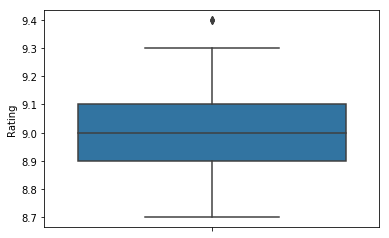

In [143]:
sns.boxplot(y=venues["Rating"], data=venues)

To get a precise distribution of the ratings, we need to create a dictionary and consequently a dataframe consisting of the ratings as keys and the counts as the values:

In [144]:
rating_count = {}

for rating in rating_list:
    rating_count[rating] = (len(venues.groupby("Rating").groups[rating]))
    
print(rating_count)

{8.7: 4, 8.8: 20, 8.9: 23, 9.0: 20, 9.1: 16, 9.2: 9, 9.3: 5, 9.4: 3}


In [145]:
rating_count_df = pd.DataFrame(rating_count, index=[0]).transpose()
rating_count_df.reset_index(inplace=True)
rating_count_df.columns = ["Rating", "Count"]
rating_count_df

,Rating,Count
0,8.7,4
1,8.8,20
2,8.9,23
3,9.0,20
4,9.1,16
5,9.2,9
6,9.3,5
7,9.4,3


Now, we visualize the counts:

Text(0.5, 1.0, 'Count vs. Rating')

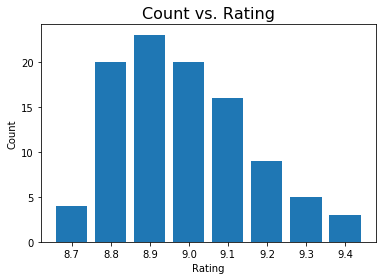

In [148]:
plt.bar(rating_count_df["Rating"],rating_count_df["Count"],width=0.08)

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count vs. Rating', fontsize=16)

It is clearly visible at first glance, that most of the venues have a rating between 8.8 and 9.1.

Finally, we check for clusters of highly rated venues and print a count of venues within each cluster:

In [158]:
venues_plot = venues[["Rating","Latitude","Longitude"]].copy()

Before running the algorithm, in order to prevent a higher weighing of the rating and/or the coordinates, we standardize/normalize the respective columns:

In [159]:
vps = StandardScaler().fit_transform(venues_plot)

In [183]:
nclusters = 8

kmeans_ns = KMeans(n_clusters=nclusters, init="k-means++", n_init=100).fit(venues_plot)
kmeans_s = KMeans(n_clusters=nclusters, init="k-means++", n_init=100).fit(vps)

# check cluster labels generated for each row in the dataframe
venues_plot_labels = kmeans_ns.labels_[0:100]
vps_labels = kmeans_s.labels_[0:100]

In [184]:
venues = pd.merge(v_0_5, rating_df, how='inner', on='ID', sort=False, copy=True)

In [185]:
venues.insert(0, 'Normal CL', kmeans_ns.labels_)
venues.insert(0, 'Normalized CL', kmeans_s.labels_)

In [186]:
venues_plot_labels

array([1, 1, 3, 3, 0, 0, 2, 2, 2, 4, 3, 3, 2, 0, 7, 4, 0, 3, 2, 2, 1, 4,
       2, 3, 0, 2, 3, 0, 2, 2, 5, 4, 0, 1, 2, 5, 2, 1, 0, 0, 0, 0, 3, 0,
       4, 3, 3, 3, 0, 4, 0, 4, 0, 0, 4, 2, 1, 3, 7, 7, 2, 2, 2, 0, 0, 0,
       6, 4, 3, 2, 6, 0, 3, 4, 1, 4, 1, 1, 2, 0, 6, 3, 2, 4, 0, 4, 6, 3,
       3, 3, 2, 0, 6, 3, 4, 7, 5, 3, 4, 4], dtype=int32)

In [187]:
vps_labels

array([1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 6, 6, 3, 4, 4, 2, 5,
       0, 0, 3, 0, 3, 0, 3, 3, 5, 5, 0, 2, 0, 2, 3, 2, 3, 6, 3, 0, 3, 3,
       2, 3, 0, 3, 3, 5, 3, 2, 0, 6, 5, 3, 2, 3, 6, 0, 3, 3, 0, 6, 3, 0,
       2, 2, 7, 3, 2, 0, 6, 7, 5, 5, 2, 2, 0, 0, 2, 0, 0, 2, 3, 5, 5, 7,
       2, 5, 0, 0, 7, 5, 3, 0, 2, 6, 2, 2], dtype=int32)

In [188]:
venues

,Normalized CL,Normal CL,Name,Category,Latitude,Longitude,Postal Code,ID,Rating
0,1,1,Greenhouse Juice Co,Juice Bar,43.679101,-79.390686,M5R,52ced2c9498e67e1059cf3b2,9.2
1,1,1,LCBO,Liquor Store,43.681497,-79.391261,M4W,4aea405ef964a52082ba21e3,9.2
2,1,3,Black Camel,BBQ Joint,43.677016,-79.389367,M4W,4ad88fa9f964a520511221e3,9.0
3,1,3,Boxcar Social,Coffee Shop,43.681750,-79.391447,M4T,5282572111d2f33612220715,9.0
4,4,0,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141,M4W,55007fd7498ed027fd04b664,8.9
5,4,0,Sabai Sabai,Thai Restaurant,43.670647,-79.384857,M4W,57f03361498e6431043a9608,8.9
6,4,2,Joso's,Mediterranean Restaurant,43.674835,-79.396171,M5R,4ad4c061f964a520a3f720e3,8.8
7,4,2,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865,M5R,554ea8bd498efa064ec03031,8.8
8,4,2,Eataly,Gourmet Shop,43.669754,-79.388720,M4W,5b2d934e59c423002c0c6db6,8.8
9,1,4,Royal Ontario Museum,Museum,43.668367,-79.394813,M5S,4ad4c05ef964a520d9f620e3,9.1


In [189]:
# The following coordinates are the coordinates of Toronto

latitude = 43.678963
longitude = -79.387207

In [190]:
nclusters = 8

cluster_list = range(0,nclusters)

cluster_color_dict = {}

red_index = 0
blue_index = 0

for cluster_n in cluster_list:
    cluster_color_dict[cluster_n] = fcs(red_list[red_index],blue_list[blue_index])
    red_index += 1
    blue_index += 1

In [191]:
cluster_color_dict

{0: '#0000FF',
 1: '#2200CC',
 2: '#4400AA',
 3: '#660088',
 4: '#880066',
 5: '#AA0044',
 6: '#CC0022',
 7: '#FF0000'}

First, let's show a map with the non-standardized kmeans clusters:

In [193]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
for ncl, nizedcl, lat, lng, venue, category, rating in zip(venues['Normal CL'], venues['Normalized CL'], venues['Latitude'], venues['Longitude'], venues['Name'], venues['Category'], venues['Rating']):
    label = 'Venue name:\n"{}"\nCategory:\n"{}"\nRating:\n"{}"'.format(venue, category, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=cluster_color_dict[ncl],
        fill_opacity=1.0,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

As can be seen, the clusters are distributed almost randomly, certainly no geographical proximity is observed between venues of the same cluster.

Now let's check the result for the standardized clusters:

In [195]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
for ncl, nizedcl, lat, lng, venue, category, rating in zip(venues['Normal CL'], venues['Normalized CL'], venues['Latitude'], venues['Longitude'], venues['Name'], venues['Category'], venues['Rating']):
    label = 'Venue name:\n"{}"\nCategory:\n"{}"\nRating:\n"{}"'.format(venue, category, rating)
    label = folium.Popup(label, parse_html=True) 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=cluster_color_dict[nizedcl],
        fill_opacity=1.0,
        parse_html=False).add_to(map_toronto)
    
map_toronto

It can be readily seen, that the clusters have been sorted according to their geographic proximity, as expected.

However, upon investigating the clusters, it is found that the colors do not represent the clusters with venues of highest rating, with the red cluster not being the one with the most and highest ranking venues. Let's correct this:

In [196]:
cluster_ratingsum_dict = {}
venue_count_per_cluster = {}
cluster_rating_dict = {}
row_cluster = ""
row_rating = ""

for i, row in venues.iterrows():
    row_cluster = row["Normalized CL"]
    row_rating = row["Rating"]
    if row_cluster in cluster_ratingsum_dict:
        venue_count_per_cluster[row_cluster] = venue_count_per_cluster[row_cluster] + 1
        cluster_ratingsum_dict[row_cluster] = cluster_ratingsum_dict[row_cluster] + row_rating
    else:
        venue_count_per_cluster[row_cluster] = 1
        cluster_ratingsum_dict[row_cluster] = row_rating
        
for cluster, number in cluster_ratingsum_dict.items():
    cluster_rating_dict[cluster] = number / venue_count_per_cluster[cluster]

print(cluster_ratingsum_dict)
print(venue_count_per_cluster)
print(cluster_rating_dict)
print("The sorted clusters from lowest to highest rated cluster:")
print(sorted(cluster_rating_dict, key=cluster_rating_dict.get))

ranked_cluster_list = sorted(cluster_rating_dict, key=cluster_rating_dict.get)

{1: 63.5, 4: 88.19999999999999, 6: 71.4, 3: 195.90000000000006, 2: 165.5, 5: 100.49999999999999, 0: 177.20000000000002, 7: 36.400000000000006}
{1: 7, 4: 10, 6: 8, 3: 22, 2: 18, 5: 11, 0: 20, 7: 4}
{1: 9.071428571428571, 4: 8.819999999999999, 6: 8.925, 3: 8.904545454545458, 2: 9.194444444444445, 5: 9.136363636363635, 0: 8.860000000000001, 7: 9.100000000000001}
The sorted clusters from lowest to highest rated cluster:
[4, 0, 3, 6, 1, 7, 5, 2]


In [197]:
i = 0

cluster_color_dict_correct = {}

for value in ranked_cluster_list:
    cluster_color_dict_correct[value]=cluster_color_dict[i]
    i += 1
    
print(cluster_color_dict_correct)

{4: '#0000FF', 0: '#2200CC', 3: '#4400AA', 6: '#660088', 1: '#880066', 7: '#AA0044', 5: '#CC0022', 2: '#FF0000'}


In [198]:
cluster_color_dict_correct

{4: '#0000FF',
 0: '#2200CC',
 3: '#4400AA',
 6: '#660088',
 1: '#880066',
 7: '#AA0044',
 5: '#CC0022',
 2: '#FF0000'}

Now, let's check the map again:

In [205]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
for ncl, nizedcl, lat, lng, venue, category, rating in zip(venues['Normal CL'], venues['Normalized CL'], venues['Latitude'], venues['Longitude'], venues['Name'], venues['Category'], venues['Rating']):
    label = 'Venue name:\n"{}"\nCategory:\n"{}"\nRating:\n"{}"\nCluster:\n"{}"'.format(venue, category, rating, nizedcl)
    label = folium.Popup(label, parse_html=True) 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=cluster_color_dict_correct[nizedcl],
        fill_opacity=1.0,
        parse_html=False).add_to(map_toronto)
    
map_toronto

As expected, the south of central Toronto has the most high-ranking venues. However, an interesting find is, that the second-lowest ranking cluster is mixed in between the highest-ranking clusters.

In [200]:
postalcode_ratingsum_dict = {}
venue_count_per_postalcode = {}
postalcode_rating_dict = {}
row_postalcode = ""
row_postalcode = ""

for i, row in venues.iterrows():
    row_postalcode = row["Postal Code"]
    row_rating = row["Rating"]
    if row_postalcode in postalcode_ratingsum_dict:
        venue_count_per_postalcode[row_postalcode] = venue_count_per_postalcode[row_postalcode] + 1
        postalcode_ratingsum_dict[row_postalcode] = postalcode_ratingsum_dict[row_postalcode] + row_rating
    else:
        venue_count_per_postalcode[row_postalcode] = 1
        postalcode_ratingsum_dict[row_postalcode] = row_rating
        
for postalcode, number in postalcode_ratingsum_dict.items():
    postalcode_rating_dict[postalcode] = number / venue_count_per_postalcode[postalcode]

print(postalcode_ratingsum_dict)
print(venue_count_per_postalcode)
print(postalcode_rating_dict)
print("The sorted postal codes from lowest to highest rated postal code:")
print(sorted(postalcode_rating_dict, key=postalcode_rating_dict.get))

ranked_postalcode_list = sorted(postalcode_rating_dict, key=postalcode_rating_dict.get)

{'M5R': 44.400000000000006, 'M4W': 71.6, 'M4T': 9.0, 'M5S': 107.10000000000001, 'M4Y': 9.0, 'M5B': 71.3, 'M5G': 9.0, 'M5A': 44.800000000000004, 'M4K': 44.9, 'M5T': 107.69999999999999, 'M5H': 72.1, 'M6G': 80.9, 'M6J': 27.299999999999997, 'M5C': 53.400000000000006, 'M5V': 73.1, 'M4P': 9.0, 'M6C': 9.1, 'M4L': 9.2, 'M4M': 18.1, 'M5E': 9.3, 'M5N': 9.0, 'M5P': 9.3}
{'M5R': 5, 'M4W': 8, 'M4T': 1, 'M5S': 12, 'M4Y': 1, 'M5B': 8, 'M5G': 1, 'M5A': 5, 'M4K': 5, 'M5T': 12, 'M5H': 8, 'M6G': 9, 'M6J': 3, 'M5C': 6, 'M5V': 8, 'M4P': 1, 'M6C': 1, 'M4L': 1, 'M4M': 2, 'M5E': 1, 'M5N': 1, 'M5P': 1}
{'M5R': 8.88, 'M4W': 8.95, 'M4T': 9.0, 'M5S': 8.925, 'M4Y': 9.0, 'M5B': 8.9125, 'M5G': 9.0, 'M5A': 8.96, 'M4K': 8.98, 'M5T': 8.975, 'M5H': 9.0125, 'M6G': 8.988888888888889, 'M6J': 9.1, 'M5C': 8.9, 'M5V': 9.1375, 'M4P': 9.0, 'M6C': 9.1, 'M4L': 9.2, 'M4M': 9.05, 'M5E': 9.3, 'M5N': 9.0, 'M5P': 9.3}
The sorted postal codes from lowest to highest rated postal code:
['M5R', 'M5C', 'M5B', 'M5S', 'M4W', 'M5A', 'M5T', 'M

In [201]:
i = 0
for item in ranked_postalcode_list:
    i += 1
print(i)

22


In [202]:
red_list_post = ["00","08","0F","18","1F","28","2F","38","3F","48","4F","58","66","77","88","99","AA","BB","CC","DD","EE","FF"]
blue_list_post = ["FF","EE","DD","CC","BB","AA","99","88","77","66","58","4F","48","3F","38","2F","28","1F","18","0F","08","00"]

In [203]:
rating_post_color_dict = {}

red_index = 0
blue_index = 0

for postalcode in ranked_postalcode_list:
    rating_post_color_dict[postalcode] = fcs(red_list_post[red_index],blue_list_post[blue_index])
    red_index += 1
    blue_index += 1

rating_post_color_dict

{'M5R': '#0000FF',
 'M5C': '#0800EE',
 'M5B': '#0F00DD',
 'M5S': '#1800CC',
 'M4W': '#1F00BB',
 'M5A': '#2800AA',
 'M5T': '#2F0099',
 'M4K': '#380088',
 'M6G': '#3F0077',
 'M4T': '#480066',
 'M4Y': '#4F0058',
 'M5G': '#58004F',
 'M4P': '#660048',
 'M5N': '#77003F',
 'M5H': '#880038',
 'M4M': '#99002F',
 'M6J': '#AA0028',
 'M6C': '#BB001F',
 'M5V': '#CC0018',
 'M4L': '#DD000F',
 'M5E': '#EE0008',
 'M5P': '#FF0000'}

In the following map, all postal codes without associated venues are removed from the map, aswell as the venues:

In [204]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood, postalcode in zip(cdfT['Latitude'], cdfT['Longitude'], cdfT['Borough'], cdfT['Neighborhood'], cdfT['PostalCode']):
    label = 'Neighborhood(s):\n"{}"\nBorough:\n"{}"\nPostal Code:\n"{}"'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    if postalcode in rating_post_color_dict:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color=rating_post_color_dict[postalcode],
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)
    else:
        pass
    
map_toronto

Since the ratings are averaged, even postal codes with one associated highly-rated venue will be displayed in red. Thus, the two districts on the outskirts of central Toronto are still colored in red.